# Bank of England Sentiment Analysis
## Employer Project
### Team 8 AnalytIQ, June 2nd, 2025
**Team Members**: Lalitha Vemuri, Christina Tsoulfa, Reka Bodo, Yann Hirsig, Louis Pang, Dr. Karin Agius Ferrante

## <span style="color:blue"> Application of different sentiment analysis scores to BoE Speeches only</span>
- VADER Sentiment Intensity Analyzer
- Polarity & Subjectivity
- BoE Wordlist
- Loughran-McDonald Master Dictionary
- Custom Dictionary
- Open AI/GPT Sentiment
- FinBERT using yiyanghkust model

## Content
1. Approach
2. Load the Data
3. Exploratory Sentiment Analysis using Natural Language Processing (NLP)
4. Conclusion

## 1. Approach

The **Bank of England (BoE)**, the UK’s central bank and one of the world’s leading financial institutions, plays a pivotal role in maintaining economic and financial stability, and supporting the UK government’s economic policies. One of its key communication channels with the public and markets is through formal speeches delivered by its representatives. These speeches aim to offer guidance, manage expectations, and provide clarity in times of uncertainty.

However, the effectiveness and impact of these speeches on economic indicators and market behaviour are not fully understood. 

This project seeks to explore whether the sentiment and timing of BoE speeches hold analytical or predictive value, when compared with economic performance and key events.

### Main Business Questions
- How do speeches and sentiment develop over time?
- How does speech sentiment relate to economic events?
- How is speech sentiment correlated with economic indicators?
- Does sentiment influence economic indicators or react to them?
- Can sentiment trends predict market behaviour?
- What broader insights can improve BoE’s communication strategy?

## 2. Load the Data

### 2.1. Import libraries

In [11]:
# Install the necessary libraries.
# !pip install nltk
# !pip install vaderSentiment
# !pip install textblob
# !pip install pandas openpyxl
# !pip install transformers torch

In [12]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('words')
# nltk.download('omw-1.4')

In [13]:
# General libraries
import numpy as np                                          # Numerical operations and array handling.
import pandas as pd                                         # Data manipulation and analysis.
import contractions                                         # Expanding/contracting text contractions.
import re                                                   # Regular expression operations on strings.
import os                                                   # Interacting with the operating system and file handling.
import matplotlib.pyplot as plt                             # Create visualisations.
from matplotlib.colors import rgb2hex                       # Colour conversion in plots.
import seaborn as sns                                       # Enhanced statistical data visualisations.
import math                                                 # Mathematical functions and constants.
from IPython.display import display, Markdown               # Rich output in Jupyter.
from functools import reduce                                # Apply functions cumulatively to lists
from sklearn.feature_extraction.text import CountVectorizer # Convert text to token counts
from collections import  Counter                            # Count item frequencies in an iterable
import plotly.express as px                                 # Create interactive plots easily

In [14]:
# Text and Sentiment Analysis 
from wordcloud import WordCloud                                       # Generating visual word frequency clouds from text.
import nltk                                                           # Natural language processing tasks.
from nltk import word_tokenize, pos_tag                               # Splitting text into words and tags with part of speech
from nltk import defaultdict                                          # Providing default values for nonexistent keys.
from nltk.probability import FreqDist                                 # Calculating frequency distribution of tokens.
from nltk.corpus import stopwords                                     # Providing list of common words to exclude from analysis.
from nltk.corpus import words                                         # Access list of English words from NLTK
from nltk.corpus import wordnet as wn                                 # Lexical database for retrieving word relationships & meanings.
from nltk.stem import WordNetLemmatizer, PorterStemmer                # Reducing words to base or root form.
from nltk.probability import FreqDist                                 # Count frequency of items in a list or text
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # Assessing sentiment intensity in text.
from textblob import TextBlob                                         # API for text processing tasks including sentiment analysis.
import contractions                                                   # Expanding/contracting text contractions.
import re                                                             # Regular expression operations on strings.
import ast                                                            # If column contains string representations of lists
from collections import defaultdict  # Creating dictionaries that return default value for nonexistent keys.
from collections import Counter  # Importing Counter for counting hashable objects and efficiently tallying occurrences in an iterable.
from transformers import AutoTokenizer                                # FinBERT Model
from transformers import AutoModelForSequenceClassification           # FinBERT Model
import torch                                                          # FinBERT Model
import torch.nn.functional as F                                       # FinBERT Model

In [15]:
# Import warnings
import warnings
# Settings for the notebook.
warnings.filterwarnings("ignore")

In [16]:
# Set figure style for seaborn.
sns.set_theme(style='darkgrid')

### 2.2. Define functions

**Cleaning the data**

In [19]:
# Load English stop words for text preprocessing tasks
stop_words = set(stopwords.words('english'))

In [20]:
# Preprocessing function
def preprocess_text(text):
    text = contractions.fix(text)  # Expand contractions i.e I'm not good goes to I am not good
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub('#', '', text)         # Remove hashtags
    text = re.sub(r'\W', ' ', text)      # Remove special characters
    text = text.lower()                  # Convert to lowercase
    #Below is to create a set of stop words from the NLTK library's predefined list but not is excluded.
    stop_words = set(stopwords.words('english')) - {'not'} 
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [21]:
# Define the tag map for POS tagging.
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Lemmatise the tokens with correct POS tags.
lemma_function = WordNetLemmatizer()

# Lemmatisation function.
def lemmatize_tokens(tokens):
    #For each word in the token list, it lemmatizes the word with the correct part-of-speech
    lemmatized_tokens = [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)]
    return lemmatized_tokens

**Vader Sentiment**

In [23]:
# VADER Sentiment Intensity Analyzer.
analyzer = SentimentIntensityAnalyzer()

# Define the function to compute and return sentiment scores.
def analyse_sentiment(text):
    return analyzer.polarity_scores(' '.join(text))

In [24]:
# Categories VADER sentiment according to compound_score
def vader_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

**Polarity & Subjectivity**

In [26]:
# Define a function to extract a polarity score using TextBlob.
def generate_polarity(comment):
    return TextBlob(comment).sentiment[0]

In [27]:
# Define a function to extract a subjectivity score using TextBlob.
def generate_subjectivity(comment):
    return TextBlob(comment).sentiment[1]

**Dictionaries**

In [29]:
# Define function to apply the lexicon to the text
def lexicon_counts(tokens):
    return pd.Series({
        cat: sum(t in word_sets[cat] for t in tokens)
        for cat in categories
    })

In [30]:
# Define function to apply the lexicon to the text
def lexicon_score_weighted(tokens):
    score = 0
    for cat in categories:
        count = sum(t in word_sets[cat] for t in tokens)
        score += count * category_weights[cat]
    return score

**Finbert**

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
# FinBERT Models: Load model 1: ProsusAI/finbert
tokenizer_prosus = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model_prosus = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert').to(device)

In [34]:
# FinBERT Models: Load model 2: yiyanghkust/finbert-tone
tokenizer_yiyang = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model_yiyang = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone').to(device)

In [35]:
# Define a function to predict probabilities in batches
def predict_batch(texts, tokenizer, model, max_length=128):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')  
    inputs = {k: v.to(device) for k, v in inputs.items()}                
    with torch.no_grad():                                              
        outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)                            
    return probs.cpu().numpy()

In [36]:
# Define function to calculate one sentiment score
def compute_tone_score(probs):
    class_labels = ['Neutral', 'Positive', 'Negative']
    prob_dict = dict(zip(class_labels, probs))
    return (
        prob_dict['Positive'] * weights['Positive'] +
        prob_dict['Neutral'] * weights['Neutral'] +
        prob_dict['Negative'] * weights['Negative']
    )

### 2.3. Import and review the data

**2.3.a. Import Bank of England Speeches**

In [39]:
# Load the CSV file as speeches.
speeches = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/all_speeches.csv')

# View the data.
speeches.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  
0  fraser       0  They would no doubt argue that to have two obj...  
1  fraser       0  Today I wish to talk about real interest rates...  
2  fraser       0  I welcome this opportunity to talk about prosp...  
3  fraser       0  It is a pleasure to have this opportunity to a...  
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...

In [40]:
# Explore data set.
speeches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reference  7721 non-null   object
 1   country    7721 non-null   object
 2   date       7721 non-null   object
 3   title      7721 non-null   object
 4   author     7721 non-null   object
 5   is_gov     7721 non-null   int64 
 6   text       7721 non-null   object
dtypes: int64(1), object(6)
memory usage: 422.4+ KB


In [41]:
# Check for missing values.
speeches.isnull().sum()

reference    0
country      0
date         0
title        0
author       0
is_gov       0
text         0
dtype: int64

In [42]:
# Check for duplicates.
speeches.duplicated().sum()

0

In [43]:
# Review basic descriptive statistics.
speeches.describe()

is_gov
count  7721.000000
mean      0.347235
std       0.476122
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000

In [44]:
# Check the number of unique values.
speeches.nunique()

reference    7721
country         8
date         4410
title        6218
author        325
is_gov          2
text         7692
dtype: int64

In [45]:
# View the countries.
speeches['country'].unique()

array(['australia', 'canada', 'euro area', 'japan', 'sweden',
       'switzerland', 'united kingdom', 'united states'], dtype=object)

In [46]:
# View the author.
speeches['author'].unique()

array(['fraser', 'macfarlane', 'lowe', 'stevens', 'no_info', 'ac',
       'thiessen', 'bonin', 'dodge', 'jenkins', 'kennedy', 'macklem',
       'duguay', 'longworth', 'carney', 'murray', 'lane', 'wolf',
       'boivin', 'cote', 'poloz', 'schembri', 'johnson', 'wilkins',
       'chilcott', 'mendes', 'patterson', 'murchison', 'leduc', 'dinis',
       'beaudry', 'gravelle', 'kozicki', 'rogers', 'morrow', 'lamfalussy',
       'duisenberg', 'vienna', 'london', 'tokyo', 'kong', 'bank',
       'schioppa', 'hamalainen', 'main', 'noyer', 'committee', 'solans',
       'francisco', 'istanbul', 'issing', 'hoogduin', 'bankwashington',
       'efma', 'brussels', 'forum', 'workshop', 'quiros', 'papademos',
       'gugerell', 'trichet', 'network', 'delivered', 'paramo',
       'strasbourg', 'rome', 'berlin', 'smaghi', 'sevilla', 'madrid',
       'stark', 'singapore', 'summit', 'washington', 'aires',
       'bratislava', 'ecb', 'constancio', 'posen', 'praet', 'draghi',
       'coeure', 'asmussen', 'mer

**2.3.b. Import Sentiment Label Lexicon**

**BoE Word List**

In [49]:
# Load the Excel file of BoE sentiment labelled wordlist.
sentiment_lexicon = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/sentiment_labelled_wordlist.xlsx')

# View the data.
sentiment_lexicon.head()

Word  Negative  Positive  Uncertainty  Litigious  Strong  Weak  \
0       ABANDON         1         0            0          0       0     0   
1     ABANDONED         1         0            0          0       0     0   
2    ABANDONING         1         0            0          0       0     0   
3   ABANDONMENT         1         0            0          0       0     0   
4  ABANDONMENTS         1         0            0          0       0     0   

   Constraining  
0             0  
1             0  
2             0  
3             0  
4             0

In [50]:
# Explore data set.
sentiment_lexicon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Word          3880 non-null   object
 1   Negative      3880 non-null   int64 
 2   Positive      3880 non-null   int64 
 3   Uncertainty   3880 non-null   int64 
 4   Litigious     3880 non-null   int64 
 5   Strong        3880 non-null   int64 
 6   Weak          3880 non-null   int64 
 7   Constraining  3880 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 242.6+ KB


In [51]:
# Check for missing values.
sentiment_lexicon.isnull().sum()

Word            0
Negative        0
Positive        0
Uncertainty     0
Litigious       0
Strong          0
Weak            0
Constraining    0
dtype: int64

In [52]:
# Review basic descriptive statistics.
sentiment_lexicon.describe()

Negative     Positive  Uncertainty    Litigious       Strong  \
count  3880.000000  3880.000000  3880.000000  3880.000000  3880.000000   
mean      0.606959     0.092268     0.076546     0.233247     0.004897   
std       0.488489     0.289441     0.265905     0.422953     0.069815   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              Weak  Constraining  
count  3880.000000   3880.000000  
mean      0.006959      0.047423  
std       0.083139      0.212569  
min       0.000000      0.000000  
25%       0.000000      0.000000  
50%       0.000000      0.000000  
75%       0.000000      0.000000  
max       1.000000      1.000000

**Loughran-McDonald_MasterDictionary used primarily for financial and corporate sentiment analysis**

In [54]:
# Load the CSV file Loughran-McDonald_MasterDictionary.
loughran_mcdonald_dict = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/Loughran-McDonald_MasterDictionary_1993-2024.csv')

# View the data.
loughran_mcdonald_dict.head()

Word  Negative  Positive  Uncertainty  Litigious  Strong_Modal  \
0   AARDVARK         0         0            0          0             0   
1  AARDVARKS         0         0            0          0             0   
2      ABACI         0         0            0          0             0   
3      ABACK         0         0            0          0             0   
4     ABACUS         0         0            0          0             0   

   Weak_Modal  Constraining  Complexity  
0           0             0           0  
1           0             0           0  
2           0             0           0  
3           0             0           0  
4           0             0           0

In [55]:
# Explore data set.
loughran_mcdonald_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86553 entries, 0 to 86552
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Word          86552 non-null  object
 1   Negative      86553 non-null  int64 
 2   Positive      86553 non-null  int64 
 3   Uncertainty   86553 non-null  int64 
 4   Litigious     86553 non-null  int64 
 5   Strong_Modal  86553 non-null  int64 
 6   Weak_Modal    86553 non-null  int64 
 7   Constraining  86553 non-null  int64 
 8   Complexity    86553 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 5.9+ MB


In [56]:
# Check for missing values.
loughran_mcdonald_dict.isnull().sum()

Word            1
Negative        0
Positive        0
Uncertainty     0
Litigious       0
Strong_Modal    0
Weak_Modal      0
Constraining    0
Complexity      0
dtype: int64

In [57]:
# Select rows where any column has a null value
rows_with_nulls = loughran_mcdonald_dict[loughran_mcdonald_dict.isnull().any(axis=1)]

rows_with_nulls

Word  Negative  Positive  Uncertainty  Litigious  Strong_Modal  \
50748  NaN         0         0            0          0             0   

       Weak_Modal  Constraining  Complexity  
50748           0             0           0

**Observation**: as no word is associated with the empty cell in word, it does not impact the analysis.

In [59]:
# Review basic descriptive statistics.
loughran_mcdonald_dict.describe()

Negative      Positive   Uncertainty     Litigious  Strong_Modal  \
count  86553.000000  86553.000000  86553.000000  86553.000000  86553.000000   
mean       0.027093      0.004009      0.003431      0.010433      0.000220   
std        0.162356      0.063191      0.058478      0.101608      0.014815   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

         Weak_Modal  Constraining    Complexity  
count  86553.000000  86553.000000  86553.000000  
mean       0.000312      0.002126      0.000612  
std        0.017659      0.046058      0.024738  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000  
75%        0.000000      0.000000      0.000000  
max        1.000000      1.000000      1.000000

In [60]:
# Check the number of unique values.
loughran_mcdonald_dict.nunique()

Word            86552
Negative            2
Positive            2
Uncertainty         2
Litigious           2
Strong_Modal        2
Weak_Modal          2
Constraining        2
Complexity          2
dtype: int64

In [61]:
# Rename the confidence index column.
loughran_mcdonald_dict.rename(columns={'Negative': 'negative_lm', 'Positive': 'positive_lm', 'Uncertainty': 'uncertainty_lm', \
                                       'Litigious': 'litigious_lm', 'Strong_Modal': 'strong_lm', 'Weak_Modal': 'weak_lm', \
                                       'Constraining': 'constraining_lm', 'Complexity': 'complexity_lm' }, inplace=True)

# View the DataFrame.
loughran_mcdonald_dict.head()

Word  negative_lm  positive_lm  uncertainty_lm  litigious_lm  \
0   AARDVARK            0            0               0             0   
1  AARDVARKS            0            0               0             0   
2      ABACI            0            0               0             0   
3      ABACK            0            0               0             0   
4     ABACUS            0            0               0             0   

   strong_lm  weak_lm  constraining_lm  complexity_lm  
0          0        0                0              0  
1          0        0                0              0  
2          0        0                0              0  
3          0        0                0              0  
4          0        0                0              0

**Custom Dictionary**

In [63]:
# Load the CSV file custom_dictionary.
custom_dict = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/custom_dictionary.csv')

# View the data.
custom_dict.head()

Word  positive_custom  negative_custom  uncertainty_custom
0      expansion                1                0                   0
1       recovery                1                0                   0
2         robust                1                0                   0
3     resilience                1                0                   0
4  strengthening                1                0                   0

In [64]:
# Explore data set.
custom_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Word                35 non-null     object
 1   positive_custom     35 non-null     int64 
 2   negative_custom     35 non-null     int64 
 3   uncertainty_custom  35 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.2+ KB


In [65]:
# Check for missing values.
custom_dict.isnull().sum()

Word                  0
positive_custom       0
negative_custom       0
uncertainty_custom    0
dtype: int64

In [66]:
# Review basic descriptive statistics.
custom_dict.describe()

positive_custom  negative_custom  uncertainty_custom
count        35.000000        35.000000           35.000000
mean          0.314286         0.428571            0.257143
std           0.471008         0.502096            0.443440
min           0.000000         0.000000            0.000000
25%           0.000000         0.000000            0.000000
50%           0.000000         0.000000            0.000000
75%           1.000000         1.000000            0.500000
max           1.000000         1.000000            1.000000

In [67]:
# Check the number of unique values.
custom_dict.nunique()

Word                  35
positive_custom        2
negative_custom        2
uncertainty_custom     2
dtype: int64

**GPT Sentiment**

In [69]:
# Load the CSV file as speeches.
gpt_sentiment = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/boe_sentiment_results.xlsx')

# View the data.
gpt_sentiment.head()

Reference                                              Title  \
0  r980915a_BOE                                             Speech   
1  r981021b_BOE                                  Britain in Europe   
2  r981021a_BOE  Impact of the recent turbulence in internation...   
3  r981101a_BOE        Economic policy, with and without forecasts   
4  r981101b_BOE  Inflation targeting in practice: the UK experi...   

  Gpt_sentiment  
0      Positive  
1      Positive  
2       Neutral  
3       Neutral  
4      Positive

In [70]:
# Rename the confidence index column.
gpt_sentiment.rename(columns={'Reference': 'reference'}, inplace=True)

# View the DataFrame.
gpt_sentiment.head()

reference                                              Title  \
0  r980915a_BOE                                             Speech   
1  r981021b_BOE                                  Britain in Europe   
2  r981021a_BOE  Impact of the recent turbulence in internation...   
3  r981101a_BOE        Economic policy, with and without forecasts   
4  r981101b_BOE  Inflation targeting in practice: the UK experi...   

  Gpt_sentiment  
0      Positive  
1      Positive  
2       Neutral  
3       Neutral  
4      Positive

In [71]:
# Rename the column
gpt_sentiment.rename(columns={'Gpt_sentiment': 'gpt_sentiment'}, inplace=True)

# View the DataFrame.
gpt_sentiment.head()

reference                                              Title  \
0  r980915a_BOE                                             Speech   
1  r981021b_BOE                                  Britain in Europe   
2  r981021a_BOE  Impact of the recent turbulence in internation...   
3  r981101a_BOE        Economic policy, with and without forecasts   
4  r981101b_BOE  Inflation targeting in practice: the UK experi...   

  gpt_sentiment  
0      Positive  
1      Positive  
2       Neutral  
3       Neutral  
4      Positive

In [72]:
# View the countries.
gpt_sentiment['gpt_sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Positive.', 'Neutral.',
       'Negative.', 'Error'], dtype=object)

In [73]:
# Function to clean up strings to exclue .
def clean_sentiment(value):
    return value.rstrip('.')  # Remove trailing periods

# Apply the function to the 'sentiment' column
gpt_sentiment['gpt_sentiment'] = gpt_sentiment['gpt_sentiment'].apply(clean_sentiment)

# View the DataFrame.
gpt_sentiment.head()

reference                                              Title  \
0  r980915a_BOE                                             Speech   
1  r981021b_BOE                                  Britain in Europe   
2  r981021a_BOE  Impact of the recent turbulence in internation...   
3  r981101a_BOE        Economic policy, with and without forecasts   
4  r981101b_BOE  Inflation targeting in practice: the UK experi...   

  gpt_sentiment  
0      Positive  
1      Positive  
2       Neutral  
3       Neutral  
4      Positive

In [74]:
# View the countries.
gpt_sentiment['gpt_sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Error'], dtype=object)

### 2.4. Date Transformation

**Speeches**

In [77]:
# Determine the date format for speeches.
speeches.date.head()

0    1990-11-28
1    1991-10-03
2    1992-03-14
3    1992-05-29
4    1992-08-17
Name: date, dtype: object

In [78]:
# Change date format from 'object' to 'datetime64' and display in a new column
speeches['date_format'] = speeches['date'].astype('datetime64[ns]')

In [79]:
# Add a new column for year and month
speeches['year_month'] = pd.to_datetime(speeches['date_format']).dt.to_period('M')

In [80]:
# Add a new column for year only
speeches['year'] = pd.to_datetime(speeches.date).dt.year

In [81]:
# Add a column for year_month in date format
speeches['year_month_dt'] = speeches['year_month'].dt.to_timestamp()

In [82]:
# View the DataFrame.
speeches.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   

  date_format year_month  year year_month_dt  
0  1990-11-28    1990-11  1990    1990-11-01  
1  1991-10-03    1991-10  1991    1991-10-01  
2  1992-03-14    1992-03  1992    1992-03-01  
3  1992-05-29    1992-05  1992    1992-05-01  
4  1992-08-17    1992-08  1992    1992-08-01

In [83]:
# View column types.
speeches.dtypes

reference                object
country                  object
date                     object
title                    object
author                   object
is_gov                    int64
text                     object
date_format      datetime64[ns]
year_month            period[M]
year                      int32
year_month_dt    datetime64[ns]
dtype: object

### 2.5. Data Correction

**2.5.a Author 'Edward George' wrongly not stated as governor**

In [88]:
# speeches given by Edward George are wrongly not stated as is_gov
def correct_is_gov_column(speeches_df: pd.DataFrame):
    # Make sure date is datetime first
    speeches['date'] = pd.to_datetime(speeches['date'], errors='coerce')
    
    # Apply correction
    condition = (
        (speeches['author'].str.lower() == 'george') &
        (speeches['date'].dt.year > 1993) &
        (speeches['date'].dt.year < 2004)
    )
    speeches.loc[condition, 'is_gov'] = 1  # 1 means Governor
    
    return speeches

# Correct the is_gov column
speeches = correct_is_gov_column(speeches)

# View the DataFrame
display(speeches[speeches['author'].str.lower() == 'george'].head())

reference         country       date              title  author  \
4961  r980915a_BOE  united kingdom 1998-09-15             Speech  george   
4962  r981021b_BOE  united kingdom 1998-10-21  Britain in Europe  george   
4966  r981119a_BOE  united kingdom 1998-11-19             Speech  george   
4969  r990112a_BOE  united kingdom 1999-01-12             Speech  george   
4970  r990118a_BOE  united kingdom 1999-01-18             Speech  george   

      is_gov                                               text date_format  \
4961       1  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962       1  It's a great pleasure to be here in the beauti...  1998-10-21   
4966       1  Let me put some of the recent newspaper headli...  1998-11-19   
4969       1  I am only too well aware of the pressure curre...  1999-01-12   
4970       1  It would be a masterly understatement to descr...  1999-01-18   

     year_month  year year_month_dt  
4961    1998-09  1998    1998-09-01  
4962    1998-10  1998    1998-10-01  
4966    1998-11  1998    1998-11-01  
4969    1999-01  1999    1999-01-01  
4970    1999-01  1999    1999-01-01

**2.5.b Remove Date Outlier**

In [90]:
# Check for earliest and latest dates
min_year = speeches['year'].min()
max_year = speeches['year'].max()

print(f"Minimum year: {min_year}")
print(f"Maximum year: {max_year}")

Minimum year: 1900
Maximum year: 2022


In [91]:
# Filter for speeches in year 1900
speeches_1900 = speeches[speeches['year'] == 1900]

# View the DataFrame
speeches_1900

reference country       date                          title  \
4010  r000101a_SRB  sweden 1900-01-01  Swedish economy in transition   

         author  is_gov                                               text  \
4010  backstrom       1  Thank you for inviting me to talk with you thi...   

     date_format year_month  year year_month_dt  
4010  1900-01-01    1900-01  1900    1900-01-01

In [92]:
# Remove the specific row with index 4010, as the date must be wrongly entered, as dates on start in 1990
# Backstrom was governor of the Bank of Sweden from 1994 to 2002.
speeches = speeches.drop(4010)

In [93]:
# Check for earliest and latest dates
min_year = speeches['year'].min()
max_year = speeches['year'].max()

print(f"Minimum year: {min_year}")
print(f"Maximum year: {max_year}")

Minimum year: 1990
Maximum year: 2022


In [94]:
# Review the DataFrame
speeches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7720 entries, 0 to 7720
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   reference      7720 non-null   object        
 1   country        7720 non-null   object        
 2   date           7720 non-null   datetime64[ns]
 3   title          7720 non-null   object        
 4   author         7720 non-null   object        
 5   is_gov         7720 non-null   int64         
 6   text           7720 non-null   object        
 7   date_format    7720 non-null   datetime64[ns]
 8   year_month     7720 non-null   period[M]     
 9   year           7720 non-null   int32         
 10  year_month_dt  7720 non-null   datetime64[ns]
dtypes: datetime64[ns](3), int32(1), int64(1), object(5), period[M](1)
memory usage: 693.6+ KB


## 3. Exploratory Sentiment Analysis & Natural Language Processing (NLP)

### 3.1. Prepare the data

**3.1.a. Filter for UK only**

In [99]:
# Bank OF England (UK) Speeches Only  
boe_speeches = speeches[speeches['country'].str.lower() == 'united kingdom'].copy()

# View the Dataframe
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year year_month_dt  
4961    1998-09  1998    1998-09-01  
4962    1998-10  1998    1998-10-01  
4963    1998-10  1998    1998-10-01  
4964    1998-11  1998    1998-11-01  
4965    1998-11  1998    1998-11-01

In [100]:
# View column types.
boe_speeches.dtypes

reference                object
country                  object
date             datetime64[ns]
title                    object
author                   object
is_gov                    int64
text                     object
date_format      datetime64[ns]
year_month            period[M]
year                      int32
year_month_dt    datetime64[ns]
dtype: object

**3.1.b. Transformation to lowercase and removal of punctuation**
- Remove elements such as hashtags and urls
- Remove any special characters and punctuation
- Convert text to lower case
- Remove stopwords

In [102]:
# Apply the cleaning function
boe_speeches['text_cleaned'] = boe_speeches['text'].apply(preprocess_text)

**3.1.c. Tokenisation of the data**<br>
Split the cleaned text into individual words, so that text can be analysed at word level.

In [104]:
# Apply the cleaning function
boe_speeches['text_tokenised'] = boe_speeches['text_cleaned'].apply(word_tokenize)

**3.1.d. Lemmatisation of the data**<br>
Reduce words to its base or dictionary form (the lemma).

In [106]:
# Apply the cleaning function
boe_speeches['text_lemmatised'] = boe_speeches['text_tokenised'].apply(lemmatize_tokens)

In [107]:
# Convert list of words into a string
boe_speeches['text_lemmatised_str'] = boe_speeches['text_lemmatised'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

**3.1.e. Include wordcount**

In [109]:
# Count the number of words in original text
boe_speeches['word_count_original'] = boe_speeches['text'].str.split().apply(len)

In [110]:
# Assuming your DataFrame is 'df' and the column is 'lemmatised_text'
boe_speeches['word_count_cleaned'] = boe_speeches['text_lemmatised_str'].str.split().apply(len)

**3.1.f. View the Results**

In [112]:
# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year year_month_dt  \
4961    1998-09  1998    1998-09-01   
4962    1998-10  1998    1998-10-01   
4963    1998-10  1998    1998-10-01   
4964    1998-11  1998    1998-11-01   
4965    1998-11  1998    1998-11-01   

                                           text_cleaned  \
4961  thank chairman actually pleased opportunity re...   
4962  great pleasure beautiful city bruges honoured ...   
4963  industries suffered volatility british economy...   
4964  topic evening use forecasts economic policy ma...   
4965  six years ago week sterling left exchange rate...   

                                         text_tokenised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industries, suffered, volatility, british, ec...   
4964  [topic, evening, use, forecasts, economic, pol...   
4965  [six, years, ago, week, sterling, left, exchan...   

                                        text_lemmatised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industry, suffer, volatility, british, econom...   
4964  [topic, evening, use, forecast, economic, poli...   
4965  [six, year, ago, week, sterling, leave, exchan...   

                                    text_lemmatised_str  word_count_original  \
4961  thank chairman actually pleased opportunity re...                 2387   
4962  great pleasure beautiful city bruges honour op...                 4045   
4963  industry suffer volatility british economy pas...                 2311   
4964  topic evening use forecast economic policy mak...                 4690   
4965  six year ago week sterling leave exchange rate...                 4452   

      word_count_cleaned  
4961                1162  
4962                2108  
4963                1240  
4964                2380  
4965                2580

### 3.2. View data in a wordclouds 

In [114]:
def show_wordcloud(counter):
    # Generate and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counter)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_top_non_stopwords_wordcloud(text):
    stop = set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    # Show the word cloud
    show_wordcloud(counter)

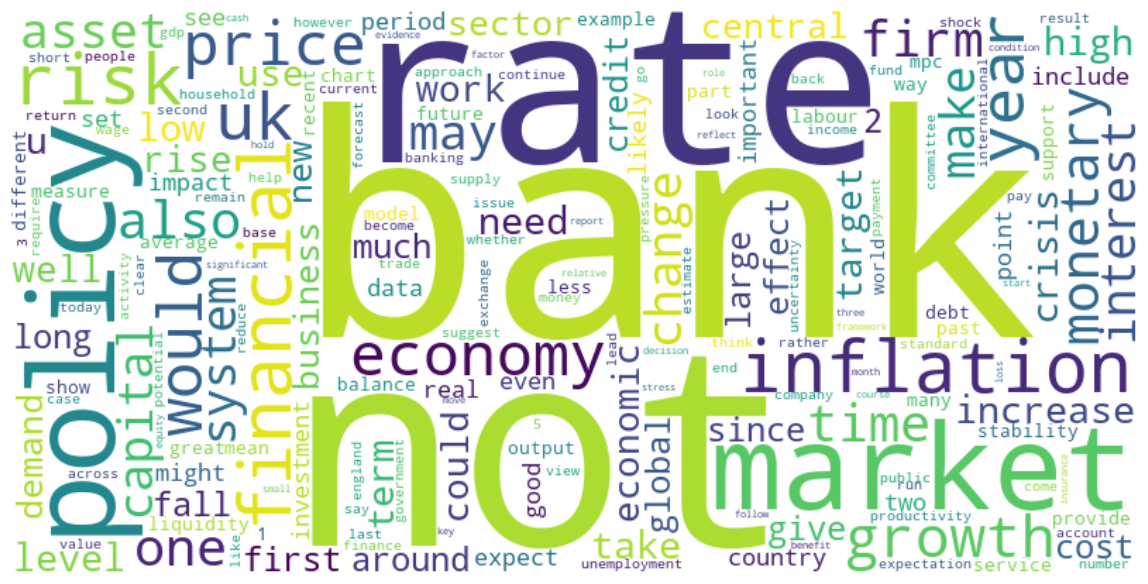

In [115]:
# Create wordcloud of lemmatised text
plot_top_non_stopwords_wordcloud(boe_speeches['text_lemmatised_str'])

In [116]:
# Define bar chart for top words
def top_words_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    # Set plot size
    plt.figure(figsize=(12, 8))
    
    # Plot
    sns.barplot(x=y, y=x)
    
    # Set label font sizes
    plt.xlabel('Count', fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.title('Top Non-Stopword Words', fontsize=16)
    plt.tight_layout()
    plt.show()

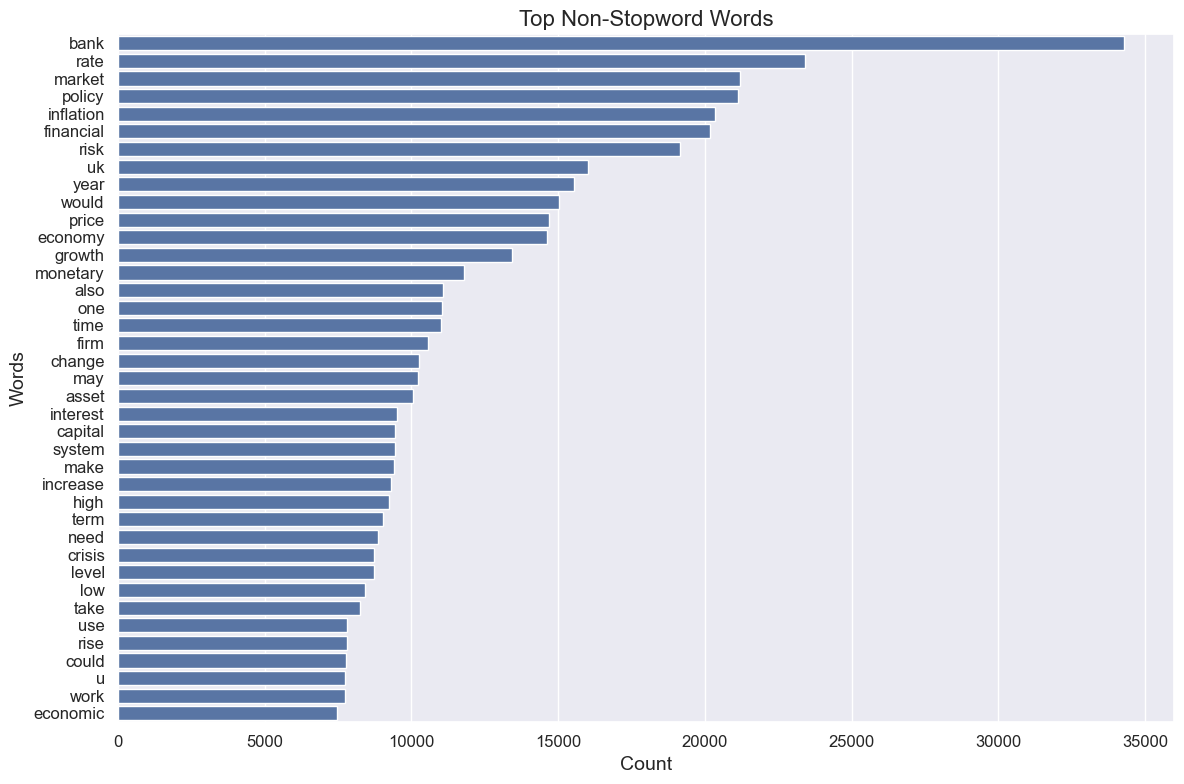

In [117]:
# Create bar chart to show top words
top_words_barchart(boe_speeches['text_lemmatised_str'])

In [118]:
# Define bar chart for top word groups
def top_word_group_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

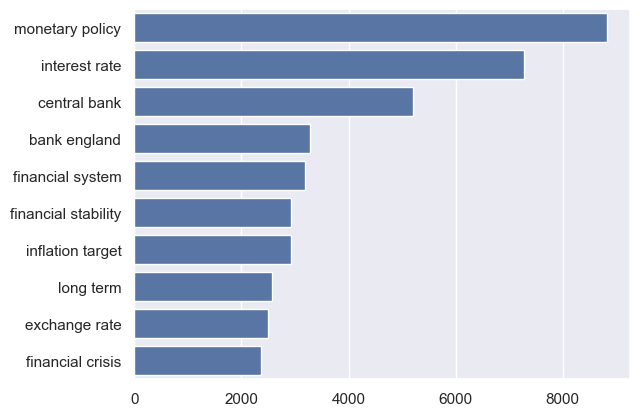

In [119]:
# Plot top phrases with 2 words
top_word_group_barchart(boe_speeches['text_lemmatised_str'],2)

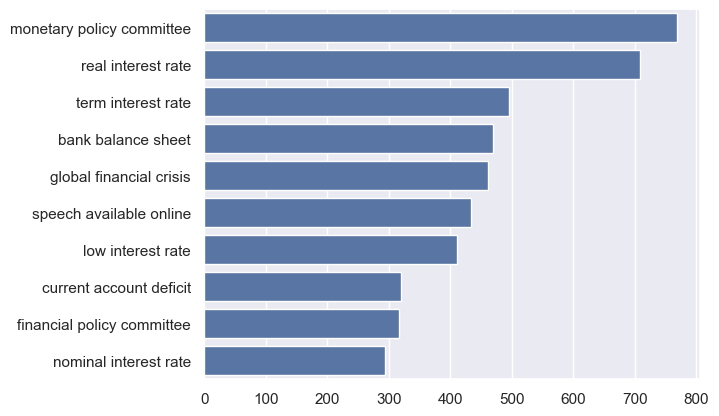

In [120]:
# Plot top phrases with 3 words
top_word_group_barchart(boe_speeches['text_lemmatised_str'],3)

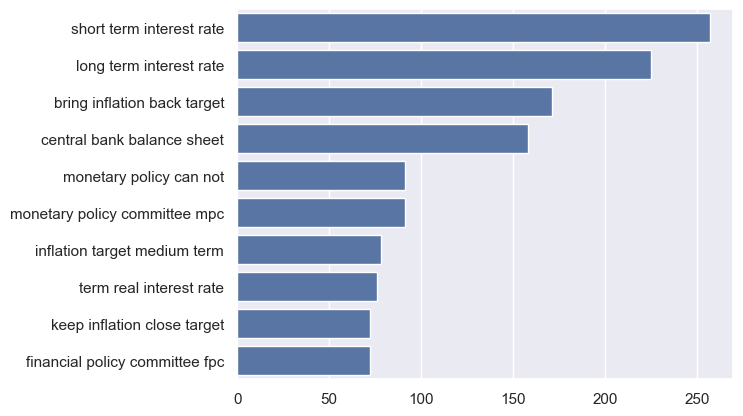

In [121]:
# Plot top phrases with 4 words
top_word_group_barchart(boe_speeches['text_lemmatised_str'],4)

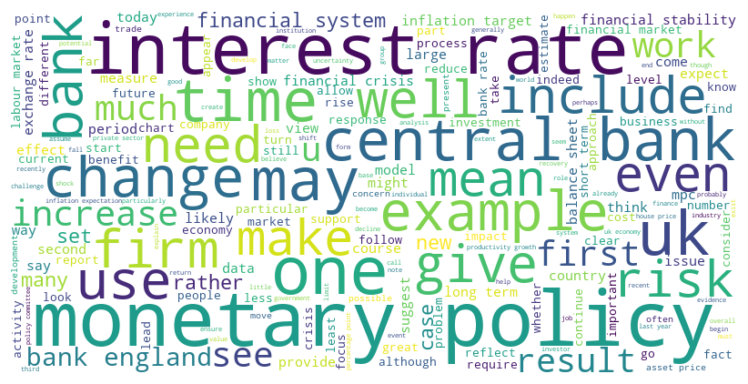

In [122]:
# Convert tokens into a single string.
boe_speeches_text = ' '.join(boe_speeches['text_lemmatised_str'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(boe_speeches_text)

# Display the word cloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')

# Hide the axis.
plt.axis('off') 

# Dispaly the word cloud.
plt.tight_layout()
plt.show()

### 3.3. Sentiment Analysis using VADER Sentiment Intensity Analyzer 

In [125]:
# Apply sentiment analysis to the columns using the lemmatised data converted into strings.
boe_speeches['sentiment_score_vader'] = boe_speeches['text_lemmatised'].apply(analyse_sentiment)

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year year_month_dt  \
4961    1998-09  1998    1998-09-01   
4962    1998-10  1998    1998-10-01   
4963    1998-10  1998    1998-10-01   
4964    1998-11  1998    1998-11-01   
4965    1998-11  1998    1998-11-01   

                                           text_cleaned  \
4961  thank chairman actually pleased opportunity re...   
4962  great pleasure beautiful city bruges honoured ...   
4963  industries suffered volatility british economy...   
4964  topic evening use forecasts economic policy ma...   
4965  six years ago week sterling left exchange rate...   

                                         text_tokenised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industries, suffered, volatility, british, ec...   
4964  [topic, evening, use, forecasts, economic, pol...   
4965  [six, years, ago, week, sterling, left, exchan...   

                                        text_lemmatised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industry, suffer, volatility, british, econom...   
4964  [topic, evening, use, forecast, economic, poli...   
4965  [six, year, ago, week, sterling, leave, exchan...   

                                    text_lemmatised_str  word_count_original  \
4961  thank chairman actually pleased opportunity re...                 2387   
4962  great pleasure beautiful city bruges honour op...                 4045   
4963  industry suffer volatility british economy pas...                 2311   
4964  topic evening use forecast economic policy mak...                 4690   
4965  six year ago week sterling leave exchange rate...                 4452   

      word_count_cleaned                              sentiment_score_vader  
4961                1162  {'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...  
4962                2108  {'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...  
4963                1240  {'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...  
4964                2380  {'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...  
4965                2580  {'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...

In [126]:
# Extract individual sentiment scores for speeches.
boe_speeches['text_neg'] = boe_speeches['sentiment_score_vader'].apply(lambda x: x['neg'])
boe_speeches['text_neu'] = boe_speeches['sentiment_score_vader'].apply(lambda x: x['neu'])
boe_speeches['text_pos'] = boe_speeches['sentiment_score_vader'].apply(lambda x: x['pos'])
boe_speeches['text_compound'] = boe_speeches['sentiment_score_vader'].apply(lambda x: x['compound'])

In [127]:
# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ...                                     text_tokenised  \
4961    1998-09  1998  ...  [thank, chairman, actually, pleased, opportuni...   
4962    1998-10  1998  ...  [great, pleasure, beautiful, city, bruges, hon...   
4963    1998-10  1998  ...  [industries, suffered, volatility, british, ec...   
4964    1998-11  1998  ...  [topic, evening, use, forecasts, economic, pol...   
4965    1998-11  1998  ...  [six, years, ago, week, sterling, left, exchan...   

                                        text_lemmatised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industry, suffer, volatility, british, econom...   
4964  [topic, evening, use, forecast, economic, poli...   
4965  [six, year, ago, week, sterling, leave, exchan...   

                                    text_lemmatised_str word_count_original  \
4961  thank chairman actually pleased opportunity re...                2387   
4962  great pleasure beautiful city bruges honour op...                4045   
4963  industry suffer volatility british economy pas...                2311   
4964  topic evening use forecast economic policy mak...                4690   
4965  six year ago week sterling leave exchange rate...                4452   

     word_count_cleaned                              sentiment_score_vader  \
4961               1162  {'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...   
4962               2108  {'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...   
4963               1240  {'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...   
4964               2380  {'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...   
4965               2580  {'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...   

      text_neg text_neu  text_pos  text_compound  
4961     0.143    0.700     0.157         0.9898  
4962     0.094    0.684     0.222         0.9998  
4963     0.106    0.732     0.161         0.9969  
4964     0.078    0.784     0.139         0.9993  
4965     0.093    0.783     0.124         0.9984  

[5 rows x 22 columns]

In [128]:
# Apply the sentiment labels to speeches
boe_speeches['vader_sentiment_score'] = boe_speeches['text_compound'].apply(vader_sentiment)

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ...                                    text_lemmatised  \
4961    1998-09  1998  ...  [thank, chairman, actually, pleased, opportuni...   
4962    1998-10  1998  ...  [great, pleasure, beautiful, city, bruges, hon...   
4963    1998-10  1998  ...  [industry, suffer, volatility, british, econom...   
4964    1998-11  1998  ...  [topic, evening, use, forecast, economic, poli...   
4965    1998-11  1998  ...  [six, year, ago, week, sterling, leave, exchan...   

                                    text_lemmatised_str word_count_original  \
4961  thank chairman actually pleased opportunity re...                2387   
4962  great pleasure beautiful city bruges honour op...                4045   
4963  industry suffer volatility british economy pas...                2311   
4964  topic evening use forecast economic policy mak...                4690   
4965  six year ago week sterling leave exchange rate...                4452   

     word_count_cleaned                              sentiment_score_vader  \
4961               1162  {'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...   
4962               2108  {'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...   
4963               1240  {'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...   
4964               2380  {'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...   
4965               2580  {'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...   

      text_neg  text_neu text_pos  text_compound  vader_sentiment_score  
4961     0.143     0.700    0.157         0.9898               Positive  
4962     0.094     0.684    0.222         0.9998               Positive  
4963     0.106     0.732    0.161         0.9969               Positive  
4964     0.078     0.784    0.139         0.9993               Positive  
4965     0.093     0.783    0.124         0.9984               Positive  

[5 rows x 23 columns]

In [129]:
# Average VADER Sentiment per year
vader_yearly = (
    boe_speeches
      .groupby('year')[['text_compound', 'text_pos', 'text_neg', 'text_neu']]
      .mean()
      .round(3)                
)

# Display the table
print("\nAverage VADER sentiment per year:")
vader_yearly


Average VADER sentiment per year:


text_compound  text_pos  text_neg  text_neu
year                                             
1998          0.997     0.161     0.107     0.732
1999          0.932     0.175     0.098     0.727
2000          0.943     0.201     0.089     0.710
2001          0.941     0.179     0.104     0.717
2002          0.932     0.189     0.104     0.707
2003          0.789     0.181     0.100     0.718
2004          0.803     0.176     0.091     0.733
2005          0.998     0.170     0.092     0.738
2006          0.876     0.175     0.098     0.727
2007          0.885     0.178     0.096     0.727
2008          0.906     0.171     0.109     0.719
2009          0.778     0.182     0.121     0.697
2010          0.781     0.170     0.114     0.716
2011          0.660     0.166     0.118     0.716
2012          0.542     0.169     0.123     0.709
2013          0.970     0.182     0.101     0.717
2014          0.737     0.178     0.115     0.707
2015          0.792     0.178     0.103     0.719
2016          0.762     0.181     0.107     0.712
2017          0.680     0.180     0.100     0.720
2018          0.954     0.181     0.092     0.727
2019          0.776     0.180     0.097     0.723
2020          0.481     0.165     0.106     0.729
2021          0.886     0.164     0.088     0.748
2022          0.793     0.164     0.092     0.744

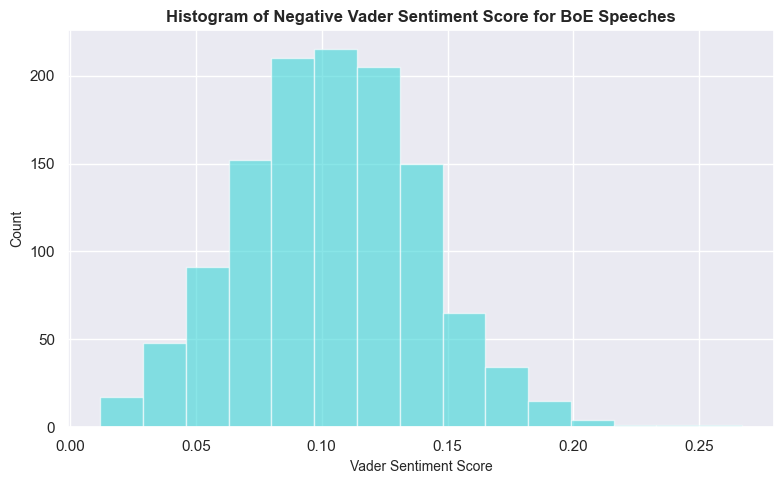

In [130]:
# Plot a histogram of the negative sentiment score
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['text_neg'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Vader Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Negative Vader Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

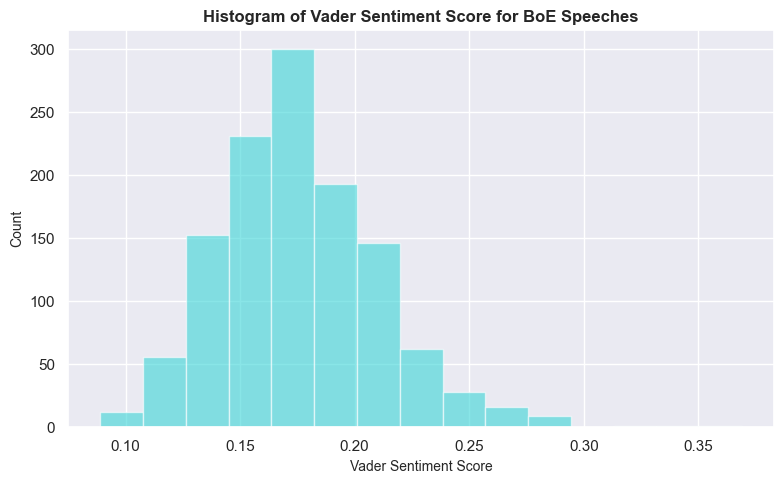

In [131]:
# Plot a histogram of the positive sentiment score
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['text_pos'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Vader Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Vader Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

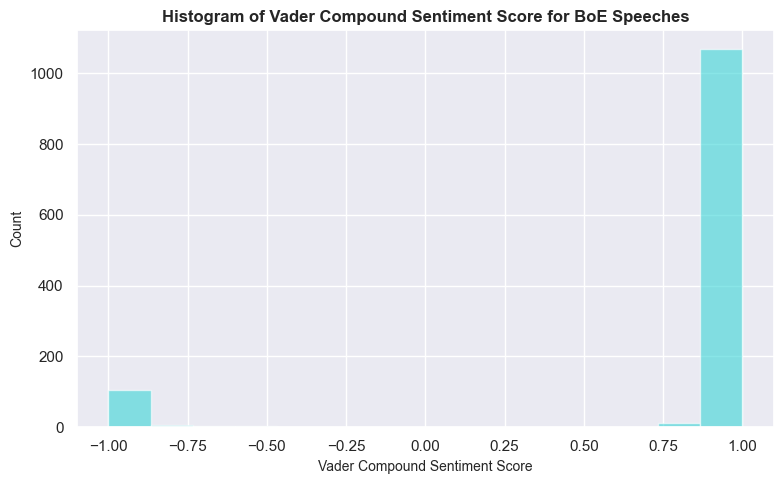

In [132]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15
# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['text_compound'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Vader Compound Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Vader Compound Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

**Observation**: Using the compound score gives a very polarised view that will not allow for a very nuanced analysis of sentiment.

### 3.4. Review Polarity and Subjectivity using TextBlob for BoE speeches

In [135]:
# Populate a new column with polarity scores for each comment.
boe_speeches['polarity_score'] = boe_speeches['text_lemmatised_str'].apply(generate_polarity)

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ...                                text_lemmatised_str  \
4961    1998-09  1998  ...  thank chairman actually pleased opportunity re...   
4962    1998-10  1998  ...  great pleasure beautiful city bruges honour op...   
4963    1998-10  1998  ...  industry suffer volatility british economy pas...   
4964    1998-11  1998  ...  topic evening use forecast economic policy mak...   
4965    1998-11  1998  ...  six year ago week sterling leave exchange rate...   

     word_count_original word_count_cleaned  \
4961                2387               1162   
4962                4045               2108   
4963                2311               1240   
4964                4690               2380   
4965                4452               2580   

                                  sentiment_score_vader text_neg  text_neu  \
4961  {'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...    0.143     0.700   
4962  {'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...    0.094     0.684   
4963  {'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...    0.106     0.732   
4964  {'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...    0.078     0.784   
4965  {'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...    0.093     0.783   

      text_pos text_compound  vader_sentiment_score  polarity_score  
4961     0.157        0.9898               Positive        0.050647  
4962     0.222        0.9998               Positive        0.062814  
4963     0.161        0.9969               Positive        0.045922  
4964     0.139        0.9993               Positive        0.041968  
4965     0.124        0.9984               Positive        0.048576  

[5 rows x 24 columns]

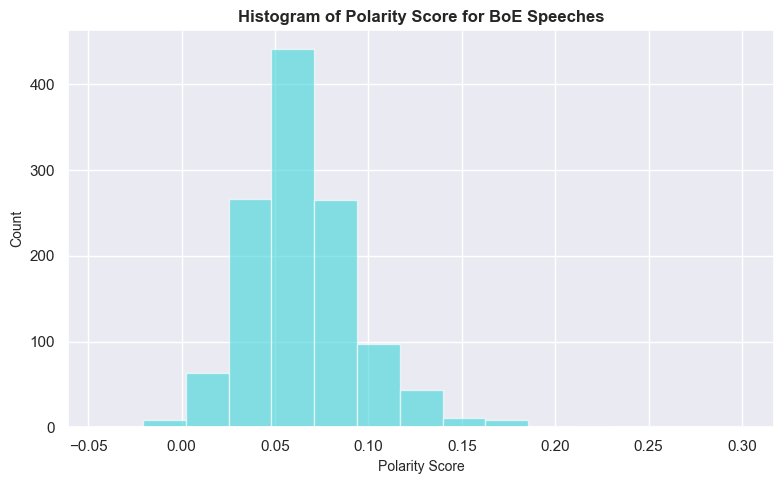

In [136]:
# Plot a histogram of the polarity score for reviews.
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the plot.
n, bins, patches = plt.hist(boe_speeches['polarity_score'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Polarity Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Polarity Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

In [137]:
# Populate a new column with polarity scores for each comment.
boe_speeches['subjectivity_score'] = boe_speeches['text_lemmatised_str'].apply(generate_subjectivity)

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... word_count_original word_count_cleaned  \
4961    1998-09  1998  ...                2387               1162   
4962    1998-10  1998  ...                4045               2108   
4963    1998-10  1998  ...                2311               1240   
4964    1998-11  1998  ...                4690               2380   
4965    1998-11  1998  ...                4452               2580   

                                  sentiment_score_vader text_neg text_neu  \
4961  {'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...    0.143    0.700   
4962  {'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...    0.094    0.684   
4963  {'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...    0.106    0.732   
4964  {'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...    0.078    0.784   
4965  {'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...    0.093    0.783   

      text_pos  text_compound vader_sentiment_score  polarity_score  \
4961     0.157         0.9898              Positive        0.050647   
4962     0.222         0.9998              Positive        0.062814   
4963     0.161         0.9969              Positive        0.045922   
4964     0.139         0.9993              Positive        0.041968   
4965     0.124         0.9984              Positive        0.048576   

      subjectivity_score  
4961            0.417626  
4962            0.351627  
4963            0.376753  
4964            0.462368  
4965            0.389893  

[5 rows x 25 columns]

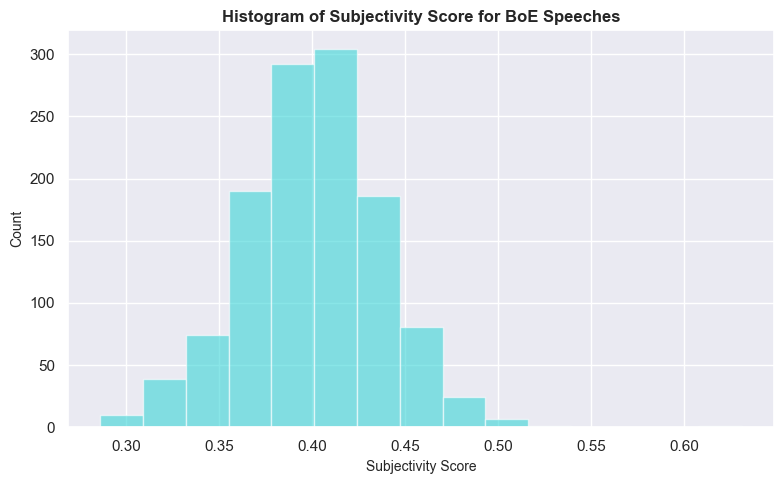

In [138]:
# Plot a histogram of the polarity score for summary.
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['subjectivity_score'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Subjectivity Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Subjectivity Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

### 3.5. Sentiment Analysis with BoE Sentiment Wordlist for BoE speeches

**3.5.a. Calculate Simple Sentiment Scores**
- positive and negative words in each speech are counted
- sentiment score = psotive word count - negative word count /  wordcount

In [141]:
# Prepare the lexicon
sentiment_lexicon = sentiment_lexicon.copy()

# Define categories
categories = [
     'Negative',
     'Positive',
     'Uncertainty',
     'Litigious',
     'Strong',
     'Weak',
     'Constraining',
 ]

# Create dictionary of categories, containing words that belong to that category based on your sentiment lexicon.
word_sets = {
    cat: set(sentiment_lexicon.loc[sentiment_lexicon[cat] == 1, 'Word'].str.lower())
    for cat in categories
}

In [142]:
# Apply the lexicon_counts function to 'text_lemmatised' column
category_counts = boe_speeches['text_lemmatised'].apply(lexicon_counts)

# Concatenate category counts to the original DataFrame
boe_speeches = pd.concat([boe_speeches, category_counts], axis=1)

# Calculate total sentiment words across all categories for each speech
boe_speeches['word_count_sentiment'] = category_counts.sum(axis=1)

# View the DataFrame
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... polarity_score subjectivity_score Negative  \
4961    1998-09  1998  ...       0.050647           0.417626       62   
4962    1998-10  1998  ...       0.062814           0.351627       80   
4963    1998-10  1998  ...       0.045922           0.376753       63   
4964    1998-11  1998  ...       0.041968           0.462368       79   
4965    1998-11  1998  ...       0.048576           0.389893      102   

     Positive Uncertainty  Litigious  Strong Weak  Constraining  \
4961       39          24          3      14   16             2   
4962       88          51          6      10   28            17   
4963       32          49          2       3   15             6   
4964       42          91         12      14   42            15   
4965       46         113         22      13   48            12   

      word_count_sentiment  
4961                   160  
4962                   280  
4963                   170  
4964                   295  
4965                   356  

[5 rows x 33 columns]

In [143]:
# Calculate the sentiment score by subtracting the negative score from the positive score
# abd dividing by the total number of words in the lemmatised text
boe_speeches['sentiment_lexicon_simple'] = (boe_speeches['Positive'] - boe_speeches['Negative'])/ boe_speeches['word_count_sentiment']

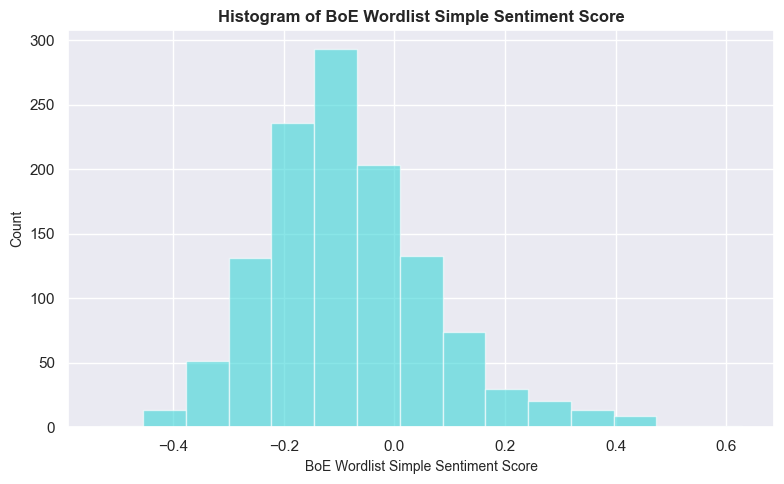

In [144]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15
# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['sentiment_lexicon_simple'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('BoE Wordlist Simple Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of BoE Wordlist Simple Sentiment Score', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

**3.5.b. Calculate weighted sentiment score with BoE Wordlist**
- words in all categories in each speech are counted (positive, negative, uncertainty, litigious, strong, weak, constraining)
- weights are applied to each category to show how important the influence on the sentiment is
- sentiment score = category counts * category weights / wordcount

**Category weights** based on importance:
- Negative -1       Standard negative words
- Positive +1.5     Standard positive words - compensate for negatively skewed wordlist
- Uncertainty 0.2   Words expressing doubt or ambiguity, less impactful than outright negative or positive words
- Litigious -0.2    Words related to lawsuits or legal issues, potentially negative or impactful depending on context
- Strong +1.5       Words with high intensity or impact, thus given more weight
- Weak +0.5         Words with less impact, so given lesser weight than 'Strong' words
- Constraining -0.5 Words implying restriction or limitations, generally negative

In [147]:
# Assign weights to the categories
category_weights = {
    'Negative': -1,
    'Positive': 1.5,
    'Uncertainty': 0.2,
    'Litigious': -0.2,
    'Strong': 1.5,
    'Weak': 0.5,
    'Constraining': -0.5
}

In [148]:
# Compute counts and store as a new column
boe_speeches['sentiment_lexicon_weighted'] = boe_speeches['text_lemmatised'].apply(lexicon_score_weighted) \
                                                    / boe_speeches['word_count_sentiment']

In [149]:
# View the DataFrame with both sentiment scores
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... Negative Positive Uncertainty Litigious Strong  \
4961    1998-09  1998  ...       62       39          24         3     14   
4962    1998-10  1998  ...       80       88          51         6     10   
4963    1998-10  1998  ...       63       32          49         2      3   
4964    1998-11  1998  ...       79       42          91        12     14   
4965    1998-11  1998  ...      102       46         113        22     13   

      Weak  Constraining word_count_sentiment  sentiment_lexicon_simple  \
4961    16             2                  160                 -0.143750   
4962    28            17                  280                  0.028571   
4963    15             6                  170                 -0.182353   
4964    42            15                  295                 -0.125424   
4965    48            12                  356                 -0.157303   

      sentiment_lexicon_weighted  
4961                    0.179375  
4962                    0.291071  
4963                    0.020000  
4964                    0.116271  
4965                    0.063764  

[5 rows x 35 columns]

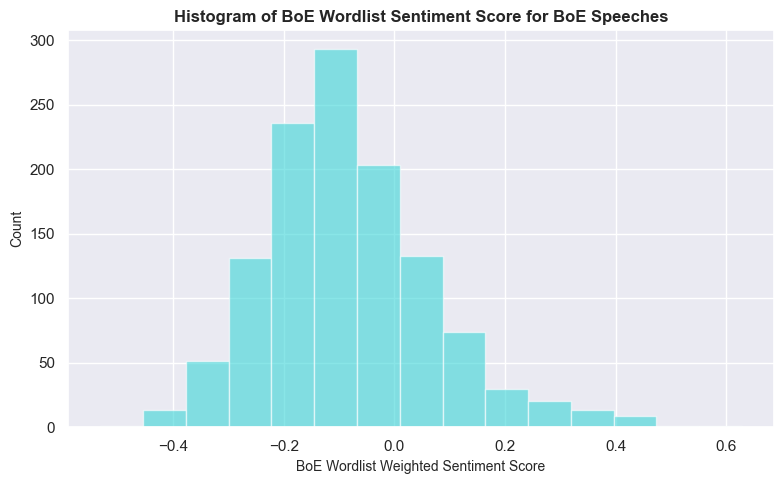

In [150]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15
# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['sentiment_lexicon_simple'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('BoE Wordlist Weighted Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of BoE Wordlist Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

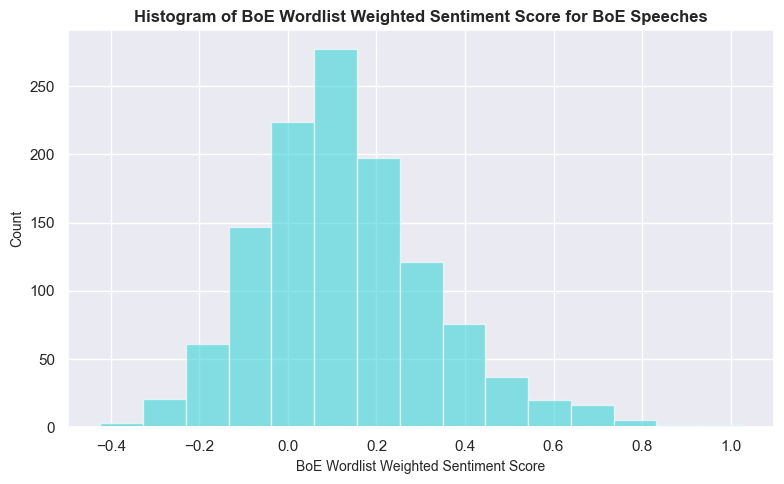

In [151]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15
# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['sentiment_lexicon_weighted'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('BoE Wordlist Weighted Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of BoE Wordlist Weighted Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

### 3.6. Sentiment Analysis with Loughran-McDonald Master Dictionary for BoE speeches

In [153]:
# Prepare the lexicon
loughran_mcdonald = loughran_mcdonald_dict.copy()

categories = [
     'negative_lm',
     'positive_lm',
     'uncertainty_lm',
     'litigious_lm',
     'strong_lm',
     'weak_lm',
     'constraining_lm',
 ]

word_sets = {
    cat: set(loughran_mcdonald.loc[loughran_mcdonald[cat] == 1, 'Word'].str.lower())
    for cat in categories
}

In [154]:
# Apply the lexicon_counts function to 'text_lemmatised' column
category_counts_lm = boe_speeches['text_lemmatised'].apply(lexicon_counts)

# Concatenate category counts to the original DataFrame
boe_speeches = pd.concat([boe_speeches, category_counts_lm], axis=1)

# Calculate total sentiment words across all categories for each speech
boe_speeches['word_count_lm'] = category_counts.sum(axis=1)

# View the DataFrame
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... sentiment_lexicon_simple  \
4961    1998-09  1998  ...                -0.143750   
4962    1998-10  1998  ...                 0.028571   
4963    1998-10  1998  ...                -0.182353   
4964    1998-11  1998  ...                -0.125424   
4965    1998-11  1998  ...                -0.157303   

     sentiment_lexicon_weighted negative_lm positive_lm uncertainty_lm  \
4961                   0.179375          61          23             24   
4962                   0.291071          79          69             51   
4963                   0.020000          59          11             49   
4964                   0.116271          77          39             91   
4965                   0.063764         101          33            113   

      litigious_lm  strong_lm weak_lm  constraining_lm  word_count_lm  
4961             3         14      16                2            160  
4962             6         10      28               17            280  
4963             2          3      15                6            170  
4964            12         14      42               15            295  
4965            22         13      48               12            356  

[5 rows x 43 columns]

In [155]:
# Calculate the sentiment score by subtracting the negative score from the positive score
boe_speeches['sentiment_lm_simple'] = (boe_speeches['positive_lm'] - boe_speeches['negative_lm'])/ boe_speeches['word_count_lm']

In [156]:
# Assign weights to the categories
category_weights = {
    'negative_lm': -1,
    'positive_lm': 1.5,
    'uncertainty_lm': 0.2,
    'litigious_lm': -0.2,
    'strong_lm': 1.5,
    'weak_lm': 0.5,
    'constraining_lm': -0.5
}

In [157]:
# Compute counts and store as a new column
boe_speeches['sentiment_lm_weighted'] = boe_speeches['text_lemmatised'].apply(lexicon_score_weighted) \
                                                    / boe_speeches['word_count_lm']

In [158]:
# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... negative_lm positive_lm uncertainty_lm  \
4961    1998-09  1998  ...          61          23             24   
4962    1998-10  1998  ...          79          69             51   
4963    1998-10  1998  ...          59          11             49   
4964    1998-11  1998  ...          77          39             91   
4965    1998-11  1998  ...         101          33            113   

     litigious_lm strong_lm  weak_lm  constraining_lm word_count_lm  \
4961            3        14       16                2           160   
4962            6        10       28               17           280   
4963            2         3       15                6           170   
4964           12        14       42               15           295   
4965           22        13       48               12           356   

      sentiment_lm_simple  sentiment_lm_weighted  
4961            -0.237500               0.035625  
4962            -0.035714               0.192857  
4963            -0.282353              -0.141765  
4964            -0.128814               0.107797  
4965            -0.191011               0.011798  

[5 rows x 45 columns]

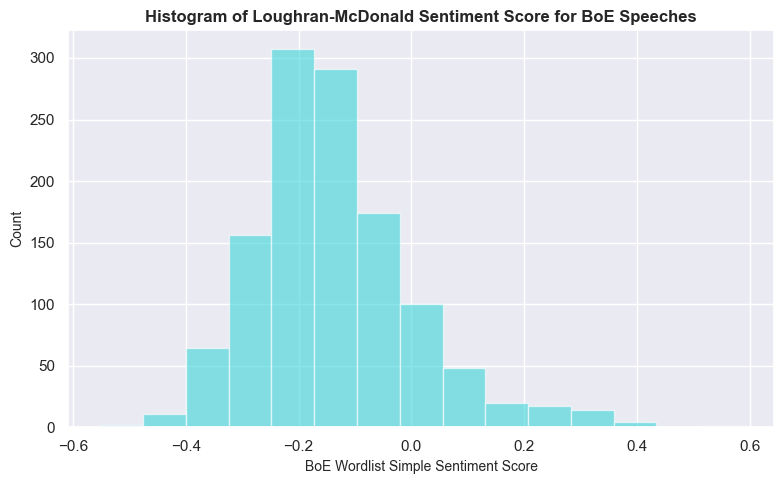

In [159]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15
# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['sentiment_lm_simple'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('BoE Wordlist Simple Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Loughran-McDonald Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

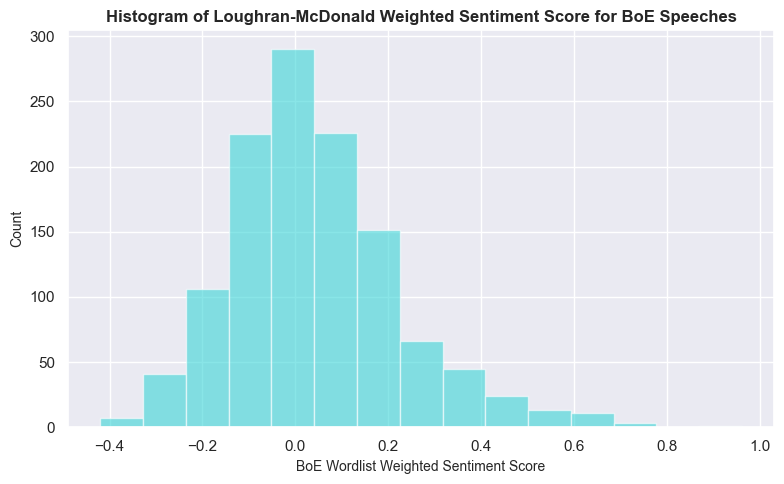

In [160]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15
# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['sentiment_lm_weighted'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('BoE Wordlist Weighted Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Loughran-McDonald Weighted Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

### 3.7. Sentiment Analysis with Custom Dictionary for BoE speeches

In [162]:
# Prepare the lexicon
custom = custom_dict.copy()

categories = [
     'negative_custom',
     'positive_custom',
     'uncertainty_custom'
 ]

word_sets = {
    cat: set(custom.loc[custom[cat] == 1, 'Word'].str.lower())
    for cat in categories
}

In [163]:
# Apply the lexicon_counts function to 'text_lemmatised' column
category_counts_custom = boe_speeches['text_lemmatised'].apply(lexicon_counts)

# Concatenate category counts to the original DataFrame
boe_speeches = pd.concat([boe_speeches, category_counts_custom], axis=1)

# Calculate total sentiment words across all categories for each speech
boe_speeches['word_count_custom'] = category_counts.sum(axis=1)

# View the DataFrame
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... strong_lm weak_lm constraining_lm word_count_lm  \
4961    1998-09  1998  ...        14      16               2           160   
4962    1998-10  1998  ...        10      28              17           280   
4963    1998-10  1998  ...         3      15               6           170   
4964    1998-11  1998  ...        14      42              15           295   
4965    1998-11  1998  ...        13      48              12           356   

     sentiment_lm_simple  sentiment_lm_weighted  negative_custom  \
4961           -0.237500               0.035625                6   
4962           -0.035714               0.192857                3   
4963           -0.282353              -0.141765                4   
4964           -0.128814               0.107797                5   
4965           -0.191011               0.011798               19   

     positive_custom  uncertainty_custom  word_count_custom  
4961               0                   9                160  
4962               0                  12                280  
4963               3                   4                170  
4964               0                  86                295  
4965               0                  24                356  

[5 rows x 49 columns]

In [164]:
# Calculate the sentiment score by subtracting the negative score from the positive score
boe_speeches['sentiment_custom_simple'] = (boe_speeches['positive_custom'] - boe_speeches['negative_custom'])/ boe_speeches['word_count_custom']

In [165]:
# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... weak_lm constraining_lm word_count_lm  \
4961    1998-09  1998  ...      16               2           160   
4962    1998-10  1998  ...      28              17           280   
4963    1998-10  1998  ...      15               6           170   
4964    1998-11  1998  ...      42              15           295   
4965    1998-11  1998  ...      48              12           356   

     sentiment_lm_simple sentiment_lm_weighted  negative_custom  \
4961           -0.237500              0.035625                6   
4962           -0.035714              0.192857                3   
4963           -0.282353             -0.141765                4   
4964           -0.128814              0.107797                5   
4965           -0.191011              0.011798               19   

      positive_custom uncertainty_custom  word_count_custom  \
4961                0                  9                160   
4962                0                 12                280   
4963                3                  4                170   
4964                0                 86                295   
4965                0                 24                356   

      sentiment_custom_simple  
4961                -0.037500  
4962                -0.010714  
4963                -0.005882  
4964                -0.016949  
4965                -0.053371  

[5 rows x 50 columns]

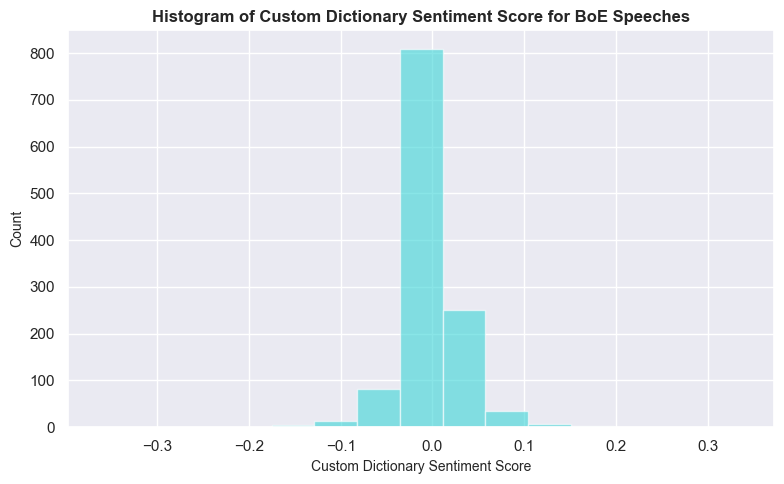

In [166]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['sentiment_custom_simple'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Custom Dictionary Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Custom Dictionary Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

**Observation**: the custom dictonary is not complete enough to give nuanced results

### 3.8. Sentiment Analysis with GPT Sentiment for BoE speeches

In [169]:
# View the DataFrame
gpt_sentiment.head()

reference                                              Title  \
0  r980915a_BOE                                             Speech   
1  r981021b_BOE                                  Britain in Europe   
2  r981021a_BOE  Impact of the recent turbulence in internation...   
3  r981101a_BOE        Economic policy, with and without forecasts   
4  r981101b_BOE  Inflation targeting in practice: the UK experi...   

  gpt_sentiment  
0      Positive  
1      Positive  
2       Neutral  
3       Neutral  
4      Positive

In [170]:
# Define the mapping dictionary
sentiment_mapping = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
}

# Apply the mapping to the sentiment column
gpt_sentiment['gpt_sentiment_numeric'] = gpt_sentiment['gpt_sentiment'].map(sentiment_mapping)

# View the DataFrame
gpt_sentiment.head()

reference                                              Title  \
0  r980915a_BOE                                             Speech   
1  r981021b_BOE                                  Britain in Europe   
2  r981021a_BOE  Impact of the recent turbulence in internation...   
3  r981101a_BOE        Economic policy, with and without forecasts   
4  r981101b_BOE  Inflation targeting in practice: the UK experi...   

  gpt_sentiment  gpt_sentiment_numeric  
0      Positive                    1.0  
1      Positive                    1.0  
2       Neutral                    0.0  
3       Neutral                    0.0  
4      Positive                    1.0

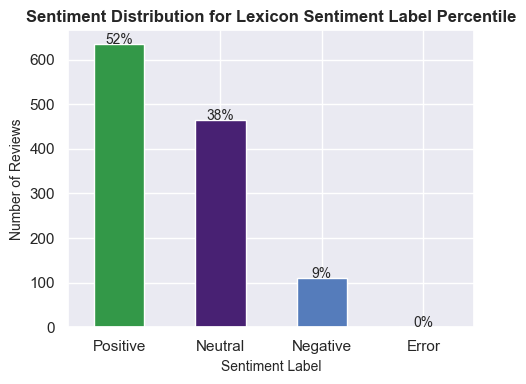

In [171]:
# Plot the sentiments distribution for lexicon percentile
sentiment_labels_gpt = gpt_sentiment['gpt_sentiment']

# Create a figure
plt.figure(figsize=(5, 4))

# Calculate the counts and percentages
sentiment_counts = pd.Series(sentiment_labels_gpt.value_counts())
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100  # Calculate percentages

# Plot the bar chart
sentiment_counts.plot(kind='bar', color=['#339848', '#482173', '#557cbb'])

# Add labels.
plt.title('Sentiment Distribution for Lexicon Sentiment Label Percentile', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment Label', fontsize=10)
plt.ylabel('Number of Reviews', fontsize=10)
plt.xticks(rotation=0)

# Annotate the bars with percentages
for index, value in enumerate(sentiment_counts):
    plt.text(index, value + 0.5, f'{sentiment_percentages[index]:.0f}%', ha='center', fontsize=10)

# Save the plot.
# plt.savefig('Fig_Sentiment_Reviews.png', dpi=500, bbox_inches='tight')

# Display the plot.
plt.tight_layout()
plt.show()

**Observation**: GPT sentiment only gives categorical results which only allows for less nuanced analysis.

### 3.9. Sentiment Analysis with FinBERT for BoE speeches

**3.4.a. Apply ProsusAI Model**

In [175]:
# Check the order of the labels in the ProsusAI model
model_prosus.config.id2label

{0: 'positive', 1: 'negative', 2: 'neutral'}

In [176]:
# Column that the model should be applied to
texts = boe_speeches['text_lemmatised'].astype(str).tolist()

# Specify batch size for efficiency
batch_size = 32
all_probs = []

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]
    batch_probs = predict_batch(batch_texts, tokenizer_prosus, model_prosus)
    all_probs.extend(batch_probs)

# Store the predicted probabilities back into your DataFrame
boe_speeches['prosus_probs'] = all_probs

# Extract top labels using the order established above
labels = ['positive', 'negative', 'neutral']

def get_probs_prosus_dict(probs):
    return {
        'prosus_positive': probs[0],
        'prosus_negative': probs[1],
        'prosus_neutral': probs[2]
    }

def get_top_label(probs):
    idx = probs.argmax()
    return labels[idx], probs.max()

In [177]:
# Create a DataFrame with all class probabilities
probs_prosus = boe_speeches['prosus_probs'].apply(lambda x: get_probs_prosus_dict(x)).apply(pd.Series)

# Assign back to your main DataFrame
boe_speeches = pd.concat([boe_speeches, probs_prosus], axis=1)

# Apply and extract label + confidence
boe_speeches[['prosus_label', 'prosus_confidence']] = boe_speeches['prosus_probs'].apply(lambda x: get_top_label(x)).apply(pd.Series)

# Now, your DataFrame has the probabilities, top label, and confidence score
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... positive_custom uncertainty_custom  \
4961    1998-09  1998  ...               0                  9   
4962    1998-10  1998  ...               0                 12   
4963    1998-10  1998  ...               3                  4   
4964    1998-11  1998  ...               0                 86   
4965    1998-11  1998  ...               0                 24   

     word_count_custom sentiment_custom_simple  \
4961               160               -0.037500   
4962               280               -0.010714   
4963               170               -0.005882   
4964               295               -0.016949   
4965               356               -0.053371   

                                prosus_probs  prosus_positive  \
4961  [0.036668405, 0.030295398, 0.93303627]         0.036668   
4962    [0.037443813, 0.02975993, 0.9327963]         0.037444   
4963    [0.026425917, 0.09654963, 0.8770244]         0.026426   
4964     [0.03381174, 0.03339488, 0.9327934]         0.033812   
4965   [0.037178747, 0.042529326, 0.9202919]         0.037179   

      prosus_negative prosus_neutral  prosus_label  prosus_confidence  
4961         0.030295       0.933036       neutral           0.933036  
4962         0.029760       0.932796       neutral           0.932796  
4963         0.096550       0.877024       neutral           0.877024  
4964         0.033395       0.932793       neutral           0.932793  
4965         0.042529       0.920292       neutral           0.920292  

[5 rows x 56 columns]

In [178]:
# Define weights 
weights = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
}

In [179]:
# Apply to all rows
boe_speeches['sentiment_score_prosus'] = boe_speeches['prosus_probs'].apply(compute_tone_score)

# View the dataframe
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... uncertainty_custom word_count_custom  \
4961    1998-09  1998  ...                  9               160   
4962    1998-10  1998  ...                 12               280   
4963    1998-10  1998  ...                  4               170   
4964    1998-11  1998  ...                 86               295   
4965    1998-11  1998  ...                 24               356   

     sentiment_custom_simple                            prosus_probs  \
4961               -0.037500  [0.036668405, 0.030295398, 0.93303627]   
4962               -0.010714    [0.037443813, 0.02975993, 0.9327963]   
4963               -0.005882    [0.026425917, 0.09654963, 0.8770244]   
4964               -0.016949     [0.03381174, 0.03339488, 0.9327934]   
4965               -0.053371   [0.037178747, 0.042529326, 0.9202919]   

     prosus_positive  prosus_negative  prosus_neutral prosus_label  \
4961        0.036668         0.030295        0.933036      neutral   
4962        0.037444         0.029760        0.932796      neutral   
4963        0.026426         0.096550        0.877024      neutral   
4964        0.033812         0.033395        0.932793      neutral   
4965        0.037179         0.042529        0.920292      neutral   

      prosus_confidence  sentiment_score_prosus  
4961           0.933036               -0.902741  
4962           0.932796               -0.903036  
4963           0.877024               -0.780475  
4964           0.932793               -0.899398  
4965           0.920292               -0.877763  

[5 rows x 57 columns]

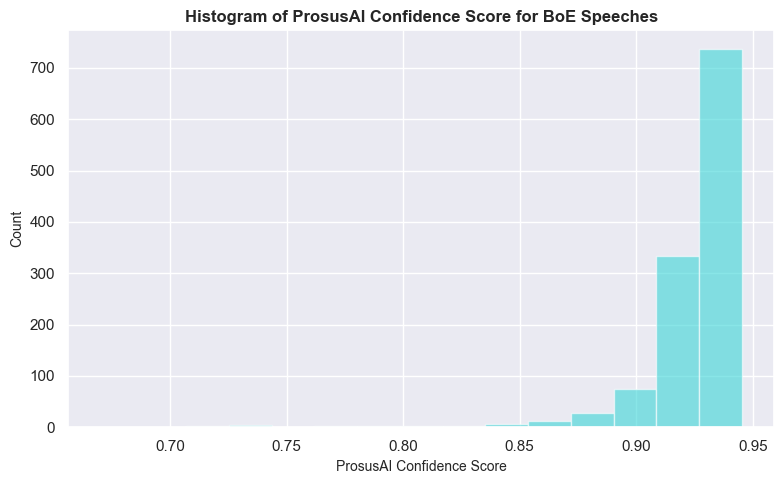

In [180]:
# Plot a histogram of the confidence score for BoE speeches
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the plot.
n, bins, patches = plt.hist(boe_speeches['prosus_confidence'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('ProsusAI Confidence Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of ProsusAI Confidence Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

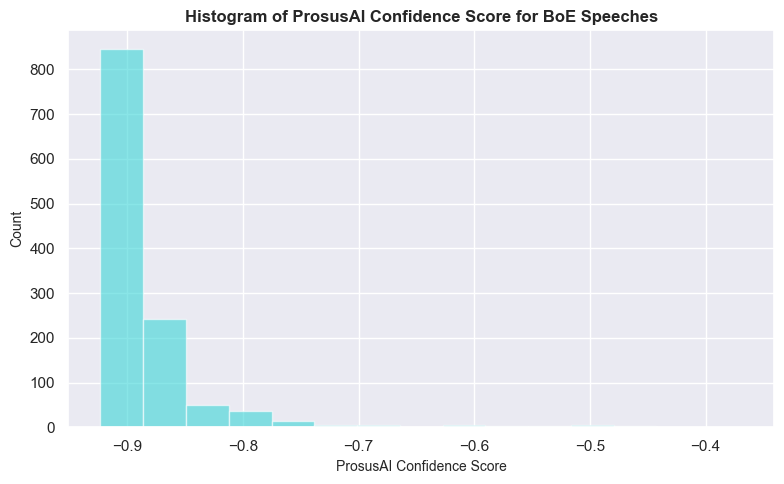

In [181]:
# Plot a histogram of the confidence score for BoE speeches
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the plot.
n, bins, patches = plt.hist(boe_speeches['sentiment_score_prosus'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('ProsusAI Confidence Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of ProsusAI Confidence Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

In [182]:
# View the weighted Sentiment scores.
boe_speeches['prosus_probs'].describe()

count                                       1209
unique                                      1209
top       [0.036668405, 0.030295398, 0.93303627]
freq                                           1
Name: prosus_probs, dtype: object

In [183]:
# View the weighted Sentiment scores.
boe_speeches['prosus_label'].nunique()

1

In [184]:
# View the weighted Sentiment scores.
boe_speeches['prosus_confidence'].describe()

count    1209.000000
mean        0.923436
std         0.025394
min         0.670076
25%         0.921743
50%         0.930312
75%         0.934870
max         0.945375
Name: prosus_confidence, dtype: float64

**3.8.b. Apply yiyanghkust model**

In [186]:
# Check the order of labels in the model
model_yiyang.config.id2label

{0: 'Neutral', 1: 'Positive', 2: 'Negative'}

In [187]:
# Column that the model should be applied to
texts = boe_speeches['text_lemmatised'].astype(str).tolist()

# Specify batch size for efficiency
batch_size = 32
all_probs = []

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]
    batch_probs = predict_batch(batch_texts, tokenizer_yiyang, model_yiyang)
    all_probs.extend(batch_probs)

# Store the predicted probabilities back into your DataFrame
boe_speeches['yiyang_probs'] = all_probs

# Extract top labels using the order established above
labels = ['Neutral', 'Positive', 'Negative']

def get_probs_yiyang_dict(probs):
    # Assumes probs is an array/list like [neutral_score, positive_score, negative_score]
    return {
        'yiyang_neutral': probs[0],
        'yiyang_positive': probs[1],
        'yiyang_negative': probs[2]
    }

def get_top_label(probs):
    idx = probs.argmax()
    return labels[idx], probs.max()

In [188]:
# Create a DataFrame with all class probabilities
probs_yiyang = boe_speeches['yiyang_probs'].apply(lambda x: get_probs_yiyang_dict(x)).apply(pd.Series)

# Assign back to your main DataFrame
boe_speeches = pd.concat([boe_speeches, probs_yiyang], axis=1)

# Apply and extract label + confidence
boe_speeches[['yiyang_label', 'yiyang_confidence']] = boe_speeches['yiyang_probs'].apply(lambda x: get_top_label(x)).apply(pd.Series)

# Now, your DataFrame has the probabilities, top label, and confidence score
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... prosus_neutral prosus_label prosus_confidence  \
4961    1998-09  1998  ...       0.933036      neutral          0.933036   
4962    1998-10  1998  ...       0.932796      neutral          0.932796   
4963    1998-10  1998  ...       0.877024      neutral          0.877024   
4964    1998-11  1998  ...       0.932793      neutral          0.932793   
4965    1998-11  1998  ...       0.920292      neutral          0.920292   

     sentiment_score_prosus                              yiyang_probs  \
4961              -0.902741     [0.4900095, 0.5094528, 0.00053772976]   
4962              -0.903036    [0.969261, 0.030696781, 4.2198746e-05]   
4963              -0.780475      [0.37933072, 0.021060491, 0.5996088]   
4964              -0.899398     [0.9847193, 0.0149205, 0.00036025542]   
4965              -0.877763  [0.9990752, 0.0009056315, 1.9160354e-05]   

      yiyang_neutral  yiyang_positive yiyang_negative  yiyang_label  \
4961        0.490009         0.509453        0.000538      Positive   
4962        0.969261         0.030697        0.000042       Neutral   
4963        0.379331         0.021060        0.599609      Negative   
4964        0.984719         0.014921        0.000360       Neutral   
4965        0.999075         0.000906        0.000019       Neutral   

      yiyang_confidence  
4961           0.509453  
4962           0.969261  
4963           0.599609  
4964           0.984719  
4965           0.999075  

[5 rows x 63 columns]

In [189]:
# Define weights 
weights = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
}

In [190]:
# Apply to all rows
boe_speeches['sentiment_score_yiyang'] = boe_speeches['yiyang_probs'].apply(compute_tone_score)

# View the dataframe
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... prosus_label prosus_confidence  \
4961    1998-09  1998  ...      neutral          0.933036   
4962    1998-10  1998  ...      neutral          0.932796   
4963    1998-10  1998  ...      neutral          0.877024   
4964    1998-11  1998  ...      neutral          0.932793   
4965    1998-11  1998  ...      neutral          0.920292   

     sentiment_score_prosus                              yiyang_probs  \
4961              -0.902741     [0.4900095, 0.5094528, 0.00053772976]   
4962              -0.903036    [0.969261, 0.030696781, 4.2198746e-05]   
4963              -0.780475      [0.37933072, 0.021060491, 0.5996088]   
4964              -0.899398     [0.9847193, 0.0149205, 0.00036025542]   
4965              -0.877763  [0.9990752, 0.0009056315, 1.9160354e-05]   

     yiyang_neutral  yiyang_positive  yiyang_negative yiyang_label  \
4961       0.490009         0.509453         0.000538     Positive   
4962       0.969261         0.030697         0.000042      Neutral   
4963       0.379331         0.021060         0.599609     Negative   
4964       0.984719         0.014921         0.000360      Neutral   
4965       0.999075         0.000906         0.000019      Neutral   

      yiyang_confidence  sentiment_score_yiyang  
4961           0.509453                0.508915  
4962           0.969261                0.030655  
4963           0.599609               -0.578548  
4964           0.984719                0.014560  
4965           0.999075                0.000886  

[5 rows x 64 columns]

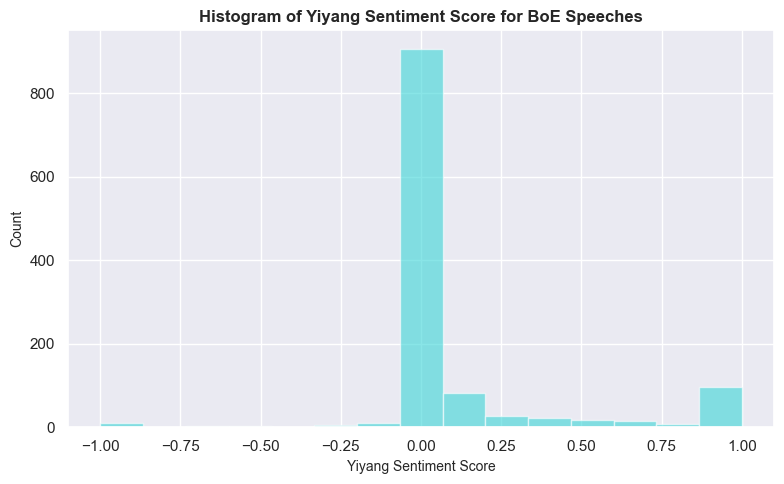

In [191]:
# Plot a histogram of the confidence score for BoE speeches
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the plot.
n, bins, patches = plt.hist(boe_speeches['sentiment_score_yiyang'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Yiyang Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Yiyang Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

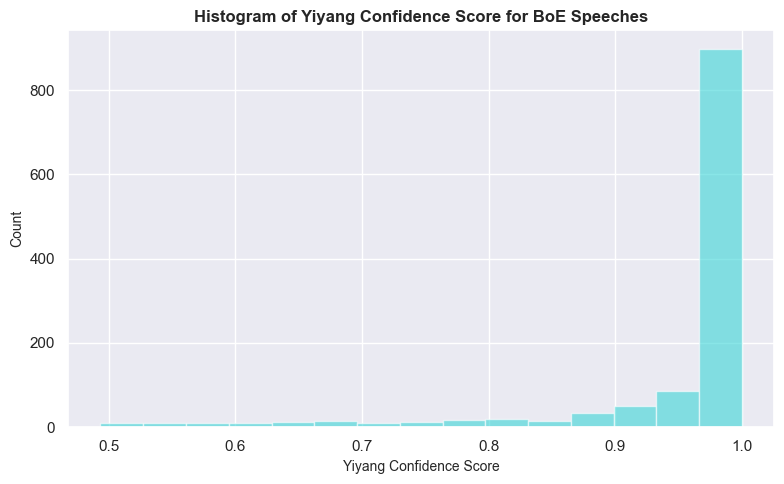

In [192]:
# Plot a histogram of the confidence score for BoE speeches
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the plot.
n, bins, patches = plt.hist(boe_speeches['yiyang_confidence'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Yiyang Confidence Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Yiyang Confidence Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

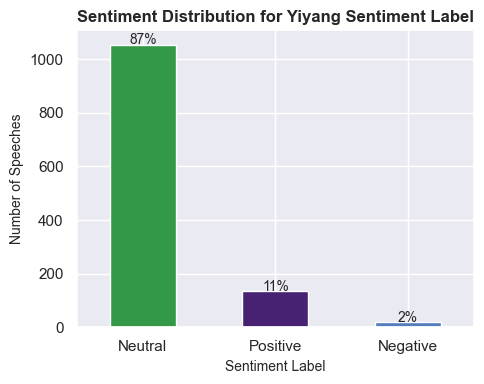

In [193]:
# Plot the sentiments distribution for yiyang
sentiment_labels_yiyang = boe_speeches['yiyang_label']

# Create a figure
plt.figure(figsize=(5, 4))

# Calculate the counts and percentages
sentiment_counts = pd.Series(sentiment_labels_yiyang.value_counts())
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100  # Calculate percentages

# Plot the bar chart
sentiment_counts.plot(kind='bar', color=['#339848', '#482173', '#557cbb'])

# Add labels.
plt.title('Sentiment Distribution for Yiyang Sentiment Label', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment Label', fontsize=10)
plt.ylabel('Number of Speeches', fontsize=10)
plt.xticks(rotation=0)

# Annotate the bars with percentages
for index, value in enumerate(sentiment_counts):
    plt.text(index, value + 0.5, f'{sentiment_percentages[index]:.0f}%', ha='center', fontsize=10)

# Save the plot.
# plt.savefig('Fig_Sentiment_Reviews.png', dpi=500, bbox_inches='tight')

# Display the plot.
plt.tight_layout()
plt.show()

In [194]:
# View the weighted Sentiment scores.
boe_speeches['yiyang_probs'].describe()

count                                      1209
unique                                     1209
top       [0.4900095, 0.5094528, 0.00053772976]
freq                                          1
Name: yiyang_probs, dtype: object

In [195]:
# View the weighted Sentiment scores.
boe_speeches['yiyang_label'].nunique()

3

In [196]:
# View the weighted Sentiment scores.
boe_speeches['sentiment_score_yiyang'].describe()

count    1209.000000
mean        0.110801
std         0.308149
min        -0.998919
25%         0.000640
50%         0.004308
75%         0.043896
max         1.000000
Name: sentiment_score_yiyang, dtype: float64

### 3.10. Compare sentiment scores

**3.5.a. Create a new dataframe with only relevant indices**

In [199]:
boe_speeches.columns

Index(['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text',
       'date_format', 'year_month', 'year', 'year_month_dt', 'text_cleaned',
       'text_tokenised', 'text_lemmatised', 'text_lemmatised_str',
       'word_count_original', 'word_count_cleaned', 'sentiment_score_vader',
       'text_neg', 'text_neu', 'text_pos', 'text_compound',
       'vader_sentiment_score', 'polarity_score', 'subjectivity_score',
       'Negative', 'Positive', 'Uncertainty', 'Litigious', 'Strong', 'Weak',
       'Constraining', 'word_count_sentiment', 'sentiment_lexicon_simple',
       'sentiment_lexicon_weighted', 'negative_lm', 'positive_lm',
       'uncertainty_lm', 'litigious_lm', 'strong_lm', 'weak_lm',
       'constraining_lm', 'word_count_lm', 'sentiment_lm_simple',
       'sentiment_lm_weighted', 'negative_custom', 'positive_custom',
       'uncertainty_custom', 'word_count_custom', 'sentiment_custom_simple',
       'prosus_probs', 'prosus_positive', 'prosus_negative', 'prosus_neutr

In [200]:
# Merge gpt_sentiment with boe_speeches
boe_speeches_new = pd.merge(boe_speeches, gpt_sentiment[['reference', 'gpt_sentiment', 'gpt_sentiment_numeric', \
                                                        ]], on='reference', how='left')

# View the DataFrame
boe_speeches_new.head()

reference         country       date  \
0  r980915a_BOE  united kingdom 1998-09-15   
1  r981021b_BOE  united kingdom 1998-10-21   
2  r981021a_BOE  united kingdom 1998-10-21   
3  r981101a_BOE  united kingdom 1998-11-01   
4  r981101b_BOE  united kingdom 1998-11-01   

                                               title   author  is_gov  \
0                                             Speech   george       1   
1                                  Britain in Europe   george       1   
2  Impact of the recent turbulence in internation...     king       1   
3        Economic policy, with and without forecasts     budd       0   
4  Inflation targeting in practice: the UK experi...  vickers       0   

                                                text date_format year_month  \
0  Thank you, Chairman. I'm actually very pleased...  1998-09-15    1998-09   
1  It's a great pleasure to be here in the beauti...  1998-10-21    1998-10   
2  Few industries have suffered more from volatil...  1998-10-21    1998-10   
3  My topic this evening is the use of forecasts ...  1998-11-01    1998-11   
4  Six years ago this week, sterling left the exc...  1998-11-01    1998-11   

   year  ... sentiment_score_prosus                              yiyang_probs  \
0  1998  ...              -0.902741     [0.4900095, 0.5094528, 0.00053772976]   
1  1998  ...              -0.903036    [0.969261, 0.030696781, 4.2198746e-05]   
2  1998  ...              -0.780475      [0.37933072, 0.021060491, 0.5996088]   
3  1998  ...              -0.899398     [0.9847193, 0.0149205, 0.00036025542]   
4  1998  ...              -0.877763  [0.9990752, 0.0009056315, 1.9160354e-05]   

  yiyang_neutral yiyang_positive yiyang_negative  yiyang_label  \
0       0.490009        0.509453        0.000538      Positive   
1       0.969261        0.030697        0.000042       Neutral   
2       0.379331        0.021060        0.599609      Negative   
3       0.984719        0.014921        0.000360       Neutral   
4       0.999075        0.000906        0.000019       Neutral   

   yiyang_confidence sentiment_score_yiyang  gpt_sentiment  \
0           0.509453               0.508915       Positive   
1           0.969261               0.030655       Positive   
2           0.599609              -0.578548        Neutral   
3           0.984719               0.014560        Neutral   
4           0.999075               0.000886       Positive   

   gpt_sentiment_numeric  
0                    1.0  
1                    1.0  
2                    0.0  
3                    0.0  
4                    1.0  

[5 rows x 66 columns]

In [201]:
# Create a new DataFrame with all sentiment scores to include for comparison.
boe_speeches_sentiment = boe_speeches_new[['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text',
                                           'date_format', 'year_month', 'year', 'year_month_dt',
                                           'text_lemmatised', 'text_lemmatised_str', 
                                           'text_compound',
                                           'sentiment_lexicon_simple', 'sentiment_lexicon_weighted',
                                           'sentiment_lm_simple', 'sentiment_lm_weighted',
                                           'sentiment_custom_simple',
                                           'gpt_sentiment_numeric',
                                           'sentiment_score_prosus', 'sentiment_score_yiyang']]

# View the DataFrame.
boe_speeches_sentiment.head()

reference         country       date  \
0  r980915a_BOE  united kingdom 1998-09-15   
1  r981021b_BOE  united kingdom 1998-10-21   
2  r981021a_BOE  united kingdom 1998-10-21   
3  r981101a_BOE  united kingdom 1998-11-01   
4  r981101b_BOE  united kingdom 1998-11-01   

                                               title   author  is_gov  \
0                                             Speech   george       1   
1                                  Britain in Europe   george       1   
2  Impact of the recent turbulence in internation...     king       1   
3        Economic policy, with and without forecasts     budd       0   
4  Inflation targeting in practice: the UK experi...  vickers       0   

                                                text date_format year_month  \
0  Thank you, Chairman. I'm actually very pleased...  1998-09-15    1998-09   
1  It's a great pleasure to be here in the beauti...  1998-10-21    1998-10   
2  Few industries have suffered more from volatil...  1998-10-21    1998-10   
3  My topic this evening is the use of forecasts ...  1998-11-01    1998-11   
4  Six years ago this week, sterling left the exc...  1998-11-01    1998-11   

   year  ...                                text_lemmatised_str text_compound  \
0  1998  ...  thank chairman actually pleased opportunity re...        0.9898   
1  1998  ...  great pleasure beautiful city bruges honour op...        0.9998   
2  1998  ...  industry suffer volatility british economy pas...        0.9969   
3  1998  ...  topic evening use forecast economic policy mak...        0.9993   
4  1998  ...  six year ago week sterling leave exchange rate...        0.9984   

  sentiment_lexicon_simple  sentiment_lexicon_weighted  sentiment_lm_simple  \
0                -0.143750                    0.179375            -0.237500   
1                 0.028571                    0.291071            -0.035714   
2                -0.182353                    0.020000            -0.282353   
3                -0.125424                    0.116271            -0.128814   
4                -0.157303                    0.063764            -0.191011   

   sentiment_lm_weighted  sentiment_custom_simple  gpt_sentiment_numeric  \
0               0.035625                -0.037500                    1.0   
1               0.192857                -0.010714                    1.0   
2              -0.141765                -0.005882                    0.0   
3               0.107797                -0.016949                    0.0   
4               0.011798                -0.053371                    1.0   

   sentiment_score_prosus  sentiment_score_yiyang  
0               -0.902741                0.508915  
1               -0.903036                0.030655  
2               -0.780475               -0.578548  
3               -0.899398                0.014560  
4               -0.877763                0.000886  

[5 rows x 22 columns]

In [202]:
# Review the data
boe_speeches_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   reference                   1209 non-null   object        
 1   country                     1209 non-null   object        
 2   date                        1209 non-null   datetime64[ns]
 3   title                       1209 non-null   object        
 4   author                      1209 non-null   object        
 5   is_gov                      1209 non-null   int64         
 6   text                        1209 non-null   object        
 7   date_format                 1209 non-null   datetime64[ns]
 8   year_month                  1209 non-null   period[M]     
 9   year                        1209 non-null   int32         
 10  year_month_dt               1209 non-null   datetime64[ns]
 11  text_lemmatised             1209 non-null   object      

**Observation**: in GPT sentiment numeric, there is a null value as there was no score calculated for this row. For further analysis this row will be removed as to not casuse any errors.

In [204]:
# Find the row that is missing the sentiment score
row_missing_score = boe_speeches_sentiment[boe_speeches_sentiment['gpt_sentiment_numeric'].isnull()]

# View the row
row_missing_score

reference         country       date  \
840  r161221a_BOE  united kingdom 2016-12-21   

                                          title author  is_gov  \
840  Increasing the relevance of Internal Audit  brown       0   

                                                  text date_format year_month  \
840  Good morning everyone. Firstly, may I say how ...  2016-12-21    2016-12   

     year  ...                                text_lemmatised_str  \
840  2016  ...  good morning everyone firstly may say grateful...   

    text_compound sentiment_lexicon_simple  sentiment_lexicon_weighted  \
840        0.9997                -0.108434                    0.155823   

     sentiment_lm_simple  sentiment_lm_weighted  sentiment_custom_simple  \
840            -0.136546               0.113655                 0.008032   

     gpt_sentiment_numeric  sentiment_score_prosus  sentiment_score_yiyang  
840                    NaN               -0.901039                 0.10815  

[1 rows x 22 columns]

In [205]:
boe_speeches_sentiment = boe_speeches_sentiment.drop(index=840)

In [206]:
# Check that there are no null values anymore
boe_speeches_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1208 entries, 0 to 1208
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   reference                   1208 non-null   object        
 1   country                     1208 non-null   object        
 2   date                        1208 non-null   datetime64[ns]
 3   title                       1208 non-null   object        
 4   author                      1208 non-null   object        
 5   is_gov                      1208 non-null   int64         
 6   text                        1208 non-null   object        
 7   date_format                 1208 non-null   datetime64[ns]
 8   year_month                  1208 non-null   period[M]     
 9   year                        1208 non-null   int32         
 10  year_month_dt               1208 non-null   datetime64[ns]
 11  text_lemmatised             1208 non-null   object        
 1

**3.5.b. Comaprison of BoE Wordlist weighted score with other scores**

In [208]:
# Correlation between BoE Wordlist weighted score and Vader score
from scipy.stats import pearsonr
corr, p_value = pearsonr(boe_speeches_sentiment['sentiment_lexicon_weighted'], boe_speeches_sentiment['text_compound'])
print(f'Correlation: {corr:.2f}')

Correlation: 0.36


In [209]:
# Correlation between BoE Wordlist weighted score and Loughran-McDonald weighted score
from scipy.stats import pearsonr
corr, p_value = pearsonr(boe_speeches_sentiment['sentiment_lexicon_weighted'], boe_speeches_sentiment['sentiment_lm_weighted'])
print(f'Correlation: {corr:.2f}')

Correlation: 0.94


In [210]:
# Correlation between BoE Wordlist weighted score and customer score
from scipy.stats import pearsonr
corr, p_value = pearsonr(boe_speeches_sentiment['sentiment_lexicon_weighted'], boe_speeches_sentiment['sentiment_custom_simple'])
print(f'Correlation: {corr:.2f}')

Correlation: 0.06


In [211]:
# Correlation between BoE Wordlist weighted score and GPT score
from scipy.stats import pearsonr
corr, p_value = pearsonr(boe_speeches_sentiment['sentiment_lexicon_weighted'], boe_speeches_sentiment['gpt_sentiment_numeric'])
print(f'Correlation: {corr:.2f}')

Correlation: 0.32


In [212]:
# Correlation between BoE Wordlist weighted score and Prosus score
from scipy.stats import pearsonr
corr, p_value = pearsonr(boe_speeches_sentiment['sentiment_lexicon_weighted'], boe_speeches_sentiment['sentiment_score_prosus'])
print(f'Correlation: {corr:.2f}')

Correlation: -0.13


In [213]:
# Correlation between BoE Wordlist weighted score and Yiyang score
from scipy.stats import pearsonr
corr, p_value = pearsonr(boe_speeches_sentiment['sentiment_lexicon_weighted'], boe_speeches_sentiment['sentiment_score_yiyang'])
print(f'Correlation: {corr:.2f}')

Correlation: 0.13


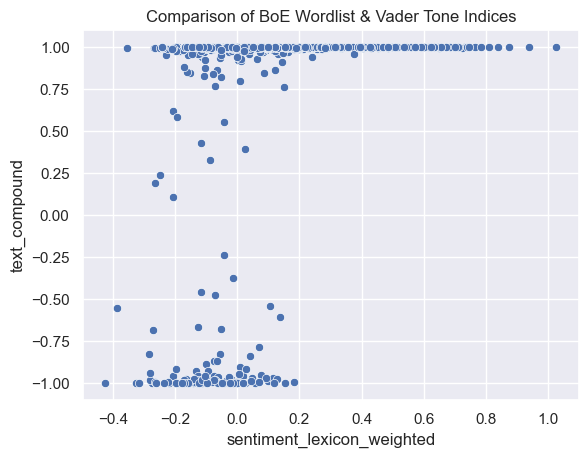

In [214]:
# Scatterplot for BoE dictionary and Finbert sentiment scores
sns.scatterplot(x='sentiment_lexicon_weighted', y='text_compound', data=boe_speeches_sentiment)
plt.title('Comparison of BoE Wordlist & Vader Tone Indices')
plt.show()

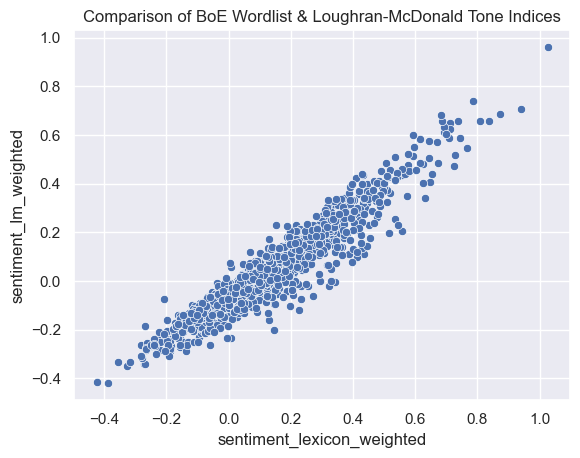

In [215]:
# Scatterplot for BoE dictionary and Finbert sentiment scores
sns.scatterplot(x='sentiment_lexicon_weighted', y='sentiment_lm_weighted', data=boe_speeches_sentiment)
plt.title('Comparison of BoE Wordlist & Loughran-McDonald Tone Indices')
plt.show()

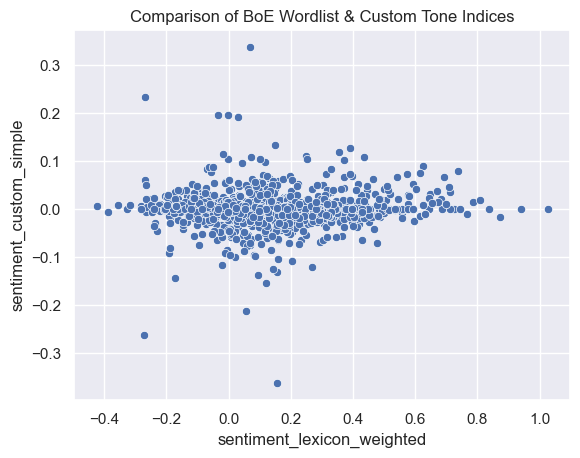

In [216]:
# Scatterplot for BoE dictionary and Finbert sentiment scores
sns.scatterplot(x='sentiment_lexicon_weighted', y='sentiment_custom_simple', data=boe_speeches_sentiment)
plt.title('Comparison of BoE Wordlist & Custom Tone Indices')
plt.show()

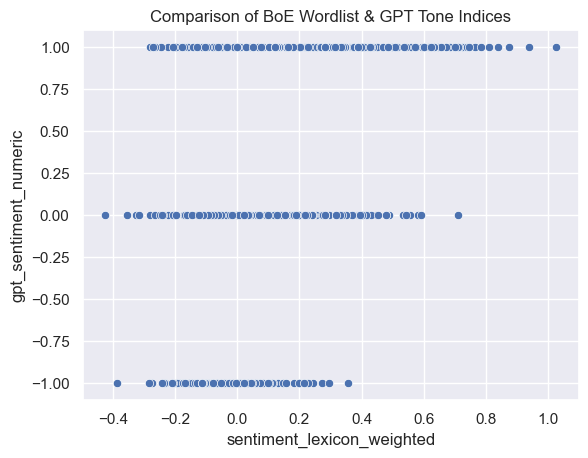

In [217]:
# Scatterplot for BoE dictionary and Finbert sentiment scores
sns.scatterplot(x='sentiment_lexicon_weighted', y='gpt_sentiment_numeric', data=boe_speeches_sentiment)
plt.title('Comparison of BoE Wordlist & GPT Tone Indices')
plt.show()

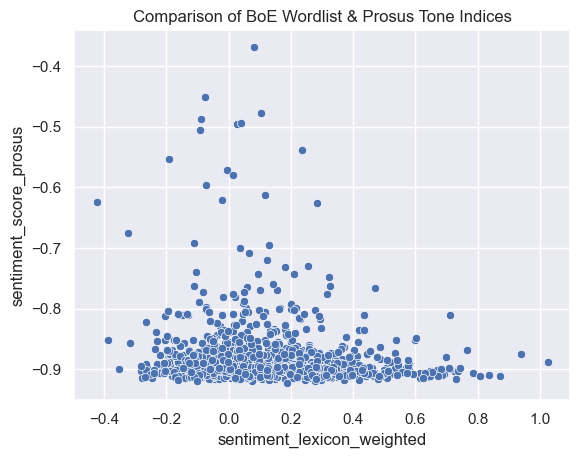

In [218]:
# Scatterplot for BoE dictionary and Finbert sentiment scores
sns.scatterplot(x='sentiment_lexicon_weighted', y='sentiment_score_prosus', data=boe_speeches_sentiment)
plt.title('Comparison of BoE Wordlist & Prosus Tone Indices')
plt.show()

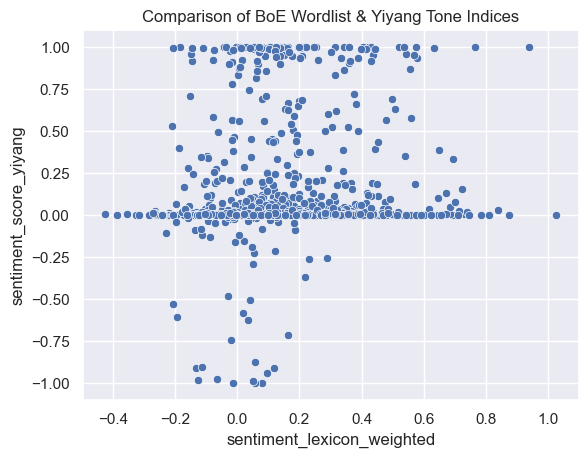

In [219]:
# Scatterplot for BoE dictionary and Finbert sentiment scores
sns.scatterplot(x='sentiment_lexicon_weighted', y='sentiment_score_yiyang', data=boe_speeches_sentiment)
plt.title('Comparison of BoE Wordlist & Yiyang Tone Indices')
plt.show()

### 3.11. Compare the sentiment scores over time

In [222]:
# Group and aggregate sentiment scores by month
sentiment_monthly = boe_speeches_sentiment.groupby('year_month_dt')[['sentiment_lexicon_weighted', 'sentiment_lm_weighted',
                                                                    'sentiment_custom_simple', 'text_compound',
                                                                     'gpt_sentiment_numeric', 'sentiment_score_prosus',
                                                                     'sentiment_score_yiyang']].mean().reset_index()
# View the DataFrame
sentiment_monthly.head()

year_month_dt  sentiment_lexicon_weighted  sentiment_lm_weighted  \
0    1998-09-01                    0.179375               0.035625   
1    1998-10-01                    0.155536               0.025546   
2    1998-11-01                    0.083057               0.007354   
3    1998-12-01                   -0.017420              -0.107789   
4    1999-01-01                    0.085728              -0.029130   

   sentiment_custom_simple  text_compound  gpt_sentiment_numeric  \
0                -0.037500       0.989800               1.000000   
1                -0.008298       0.998350               0.500000   
2                -0.048131       0.996767               0.333333   
3                -0.007644       0.999350               0.500000   
4                -0.013645       0.997550               0.500000   

   sentiment_score_prosus  sentiment_score_yiyang  
0               -0.902741                0.508915  
1               -0.841756               -0.273947  
2               -0.868495                0.005471  
3               -0.882889                0.000804  
4               -0.879063               -0.074447

In [223]:
# Review the DataFrame
sentiment_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   year_month_dt               272 non-null    datetime64[ns]
 1   sentiment_lexicon_weighted  272 non-null    float64       
 2   sentiment_lm_weighted       272 non-null    float64       
 3   sentiment_custom_simple     272 non-null    float64       
 4   text_compound               272 non-null    float64       
 5   gpt_sentiment_numeric       272 non-null    float64       
 6   sentiment_score_prosus      272 non-null    float64       
 7   sentiment_score_yiyang      272 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 17.1 KB


**4.1.a. Analysis by month**

In [225]:
# Plot all sentiment scores over time

# Define the plot
fig = px.line(
     sentiment_monthly,
     x='year_month_dt',
     y=['sentiment_lexicon_weighted', 'sentiment_lm_weighted','sentiment_custom_simple', 'text_compound', 'gpt_sentiment_numeric', 
        'sentiment_score_prosus', 'sentiment_score_yiyang'],
     title="Average monthly sentiment scores – Bank of England speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Display the plot
fig.show()

In [226]:
# Plot sentiment scores over time

# Define the plot
fig = px.line(
     sentiment_monthly,
     x='year_month_dt',
     y=['sentiment_lexicon_weighted', 'sentiment_lm_weighted','sentiment_custom_simple'],
     title="Average monthly sentiment scores – Bank of England speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Display the plot
fig.show()

In [227]:
# Plot sentiment scores over time

# Define the plot
fig = px.line(
     sentiment_monthly,
     x='year_month_dt',
     y=['sentiment_lexicon_weighted', 'text_compound', 'gpt_sentiment_numeric'],
     title="Average monthly BoE Wordlist and GPT sentiment scores – Bank of England speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Display the plot
fig.show()

**Observation**: Analysis per month does not allow for an easy comaprison.

**4.1.b. Analysis by year**

In [230]:
# Group and aggregate sentiment scores by year
sentiment_yearly = boe_speeches_sentiment.groupby('year')[['sentiment_lexicon_weighted', 'sentiment_lm_weighted',
                                                           'sentiment_custom_simple', 'text_compound',
                                                           'gpt_sentiment_numeric', 'sentiment_score_prosus',
                                                           'sentiment_score_yiyang']].mean().reset_index()
# View the DataFrame
sentiment_yearly.head()

year  sentiment_lexicon_weighted  sentiment_lm_weighted  \
0  1998                    0.088097              -0.013350   
1  1999                    0.185937               0.092326   
2  2000                    0.308585               0.194342   
3  2001                    0.148234               0.028793   
4  2002                    0.236919               0.110411   

   sentiment_custom_simple  text_compound  gpt_sentiment_numeric  \
0                -0.026722       0.996938               0.500000   
1                -0.009409       0.931620               0.566667   
2                -0.004075       0.943356               0.750000   
3                -0.009413       0.940815               0.550000   
4                 0.000955       0.932003               0.566667   

   sentiment_score_prosus  sentiment_score_yiyang  
0               -0.869689               -0.002620  
1               -0.886250                0.078114  
2               -0.889221                0.250059  
3               -0.866716                0.111880  
4               -0.879339                0.098691

In [231]:
fig = px.line(
     sentiment_yearly,
     x='year',
     y=['sentiment_lexicon_weighted', 'sentiment_lm_weighted', 'sentiment_custom_simple', 'text_compound',
        'gpt_sentiment_numeric', 'sentiment_score_prosus', 'sentiment_score_yiyang'],
     title='Average Yearly Sentiment Scores – BoE Speeches (1997–2022)',
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Set mode to lines+markers for all traces and customise
for trace in fig.data:
    trace.mode = 'lines+markers'
    trace.marker = dict(symbol='circle', size=6)

# Update size
fig.update_layout(width=1100, height=600)

# Move legend outside to the right
fig.update_layout(
    legend=dict(
        x=1.05,
        y=1,
        xanchor='left',
        yanchor='top'
    ),
    # Set legend title
    legend_title_text='Legend'
)

# Rename legend entries
new_names = {
    'sentiment_lexicon_weighted': 'BoE Wordlist Weighted',
    'sentiment_lm_weighted': 'Loughran-McDonald Weighted',
    'sentiment_custom_simple': 'Custom Dictionary Simple',
    'text_compound': 'Vader Score',
    'gpt_sentiment_numeric': 'GPT Score',
    'sentiment_score_prosus': 'Prosus Score',
    'sentiment_score_yiyang': 'Yiyang Score'
}

for trace in fig.data:
    if trace.name in new_names:
        trace.name = new_names[trace.name]

fig.show()

In [232]:
fig = px.line(
    sentiment_yearly,
    x='year',
    y=[
        'sentiment_lexicon_weighted',
        'sentiment_lm_weighted',
        'sentiment_custom_simple',
        'text_compound',
        'gpt_sentiment_numeric',
        'sentiment_score_prosus',
        'sentiment_score_yiyang'
    ],
    title='Average Yearly Sentiment Scores – BoE Speeches (1997–2022)',
    labels={'value': 'Average score', 'variable': 'Legend'}
)

# Add dots to lines
for trace in fig.data:
    trace.mode = 'lines+markers'
    trace.marker = dict(symbol='circle', size=6)

# Define specific event years and labels
event_years = [2008, 2016, 2020]
event_labels = ['Global Financial Crisis', 'Brexit Referendum', 'Covid 19']

shapes = []
annotations = []

for year, label in zip(event_years, event_labels):
    shapes.append(
        dict(
            type='line',
            x0=year,
            y0=0,
            x1=year,
            y1=1,
            xref='x',
            yref='paper',
            line=dict(color='dark grey', width=2, dash='dot')  # smaller dashed line
        )
    )
    # Label position just above the top
    annotations.append(
        dict(
            x=year,
            y=1,
            xref='x',
            yref='paper',
            text=label,
            showarrow=False,
            xanchor='left',
            yanchor='bottom',
            font=dict(size=10, color='dark grey')
        )
    )

# Apply shapes and labels
fig.update_layout(
    width=1100,
    height=600,
    legend=dict(x=1.05, y=1, xanchor='left', yanchor='top'),
    legend_title_text='Legend',
    shapes=shapes,
    annotations=annotations
)

# Rename legend entries
new_names = {
    'sentiment_lexicon_weighted': 'BoE Wordlist Weighted',
    'sentiment_lm_weighted': 'Loughran-McDonald Weighted',
    'sentiment_custom_simple': 'Custom Dictionary Simple',
    'text_compound': 'Vader Score',
    'gpt_sentiment_numeric': 'GPT Score',
    'sentiment_score_prosus': 'Prosus Score',
    'sentiment_score_yiyang': 'Yiyang Score'
}

for trace in fig.data:
    if trace.name in new_names:
        trace.name = new_names[trace.name]

fig.show()

In [233]:
# Plot sentiment scores over time

# Define the plot
fig = px.line(
     sentiment_yearly,
     x='year',
     y=['sentiment_lexicon_weighted', 'sentiment_lm_weighted','sentiment_custom_simple'],
     title="Average yearly BoE Wordlist Weighted and GPT sentiment scores – BoE Speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Display the plot
fig.show()

In [234]:
# Plot sentiment scores over time

# Define the plot
fig = px.line(
     sentiment_yearly,
     x='year',
     y=['sentiment_lexicon_weighted', 'text_compound', 'gpt_sentiment_numeric'],
     title="Average yearly BoE Wordlist, GPT and FinBert sentiment scores – BoE Speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Display the plot
fig.show()

**4.1.c. Analysis by quarter/ 3 month averages**

In [236]:
# Group and aggregate sentiment scores by quarter
sentiment_quarterly = boe_speeches_sentiment.groupby(pd.Grouper(key='year_month_dt', freq='Q'))[
    ['sentiment_lexicon_weighted', 'sentiment_lm_weighted', 'sentiment_custom_simple', 'text_compound',
     'gpt_sentiment_numeric', 'sentiment_score_prosus', 'sentiment_score_yiyang']
].mean().reset_index()

# View the DataFrane
sentiment_quarterly.head()

year_month_dt  sentiment_lexicon_weighted  sentiment_lm_weighted  \
0    1998-09-30                    0.179375               0.035625   
1    1998-12-31                    0.075058              -0.020346   
2    1999-03-31                    0.220248               0.088592   
3    1999-06-30                    0.303026               0.209232   
4    1999-09-30                    0.004935              -0.030464   

   sentiment_custom_simple  text_compound  gpt_sentiment_numeric  \
0                -0.037500       0.989800               1.000000   
1                -0.025183       0.997957               0.428571   
2                -0.009457       0.998750               0.625000   
3                -0.018257       0.999413               0.500000   
4                -0.007831       0.598580               0.400000   

   sentiment_score_prosus  sentiment_score_yiyang  
0               -0.902741                0.508915  
1               -0.864968               -0.075696  
2               -0.878348                0.120756  
3               -0.896679                0.147219  
4               -0.884575                0.015469

In [237]:
# View the DataFrane
sentiment_quarterly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   year_month_dt               98 non-null     datetime64[ns]
 1   sentiment_lexicon_weighted  98 non-null     float64       
 2   sentiment_lm_weighted       98 non-null     float64       
 3   sentiment_custom_simple     98 non-null     float64       
 4   text_compound               98 non-null     float64       
 5   gpt_sentiment_numeric       98 non-null     float64       
 6   sentiment_score_prosus      98 non-null     float64       
 7   sentiment_score_yiyang      98 non-null     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 6.3 KB


In [238]:
# Plot sentiment scores over time

# Define the plot
fig = px.line(
     sentiment_quarterly,
     x='year_month_dt',
     y=['sentiment_lexicon_weighted', 'sentiment_lm_weighted', 'sentiment_custom_simple', 'text_compound',
        'gpt_sentiment_numeric', 'sentiment_score_prosus', 'sentiment_score_yiyang'],
     title="Average quaterly BoE Wordlist and GPT sentiment scores – BoE Speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Display the plot
fig.show()

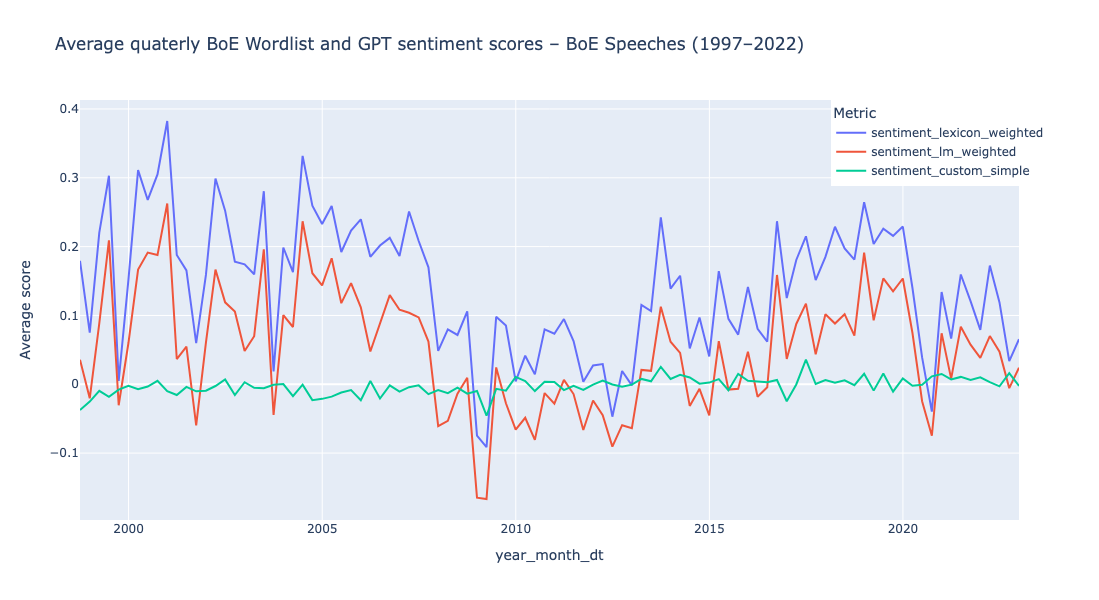

In [239]:
# Plot sentiment scores over time

# Define the plot
fig = px.line(
     sentiment_quarterly,
     x='year_month_dt',
     y=['sentiment_lexicon_weighted', 'sentiment_lm_weighted','sentiment_custom_simple'],
     title="Average quaterly BoE Wordlist and GPT sentiment scores – BoE Speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Display the plot
fig.show()

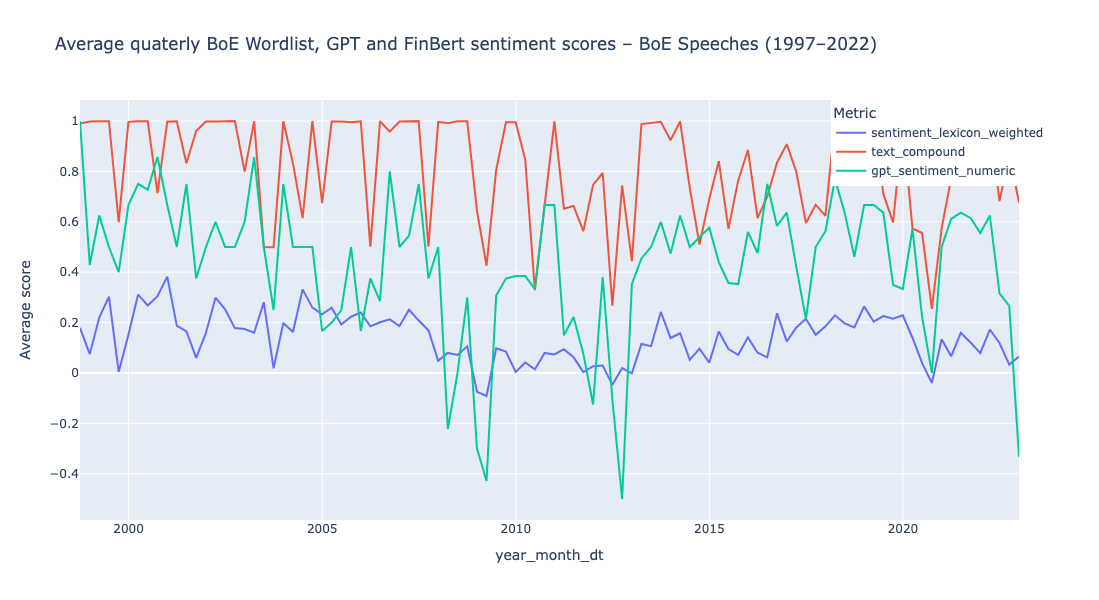

In [240]:
# Plot sentiment scores over time

# Define the plot
fig = px.line(
     sentiment_quarterly,
     x='year_month_dt',
     y=['sentiment_lexicon_weighted', 'text_compound', 'gpt_sentiment_numeric'],
     title="Average quaterly BoE Wordlist, GPT and FinBert sentiment scores – BoE Speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Display the plot
fig.show()

## 4. Conclusion

**Vader Sentiment**
- Benefit: easy & fast
- Drawback: limited in capturing complex sentiments

**Polarity & Subjectivity**
- Benefit: easy & fast
- Drawback: sensitive to context

**BoE Sentiment Wordlist**
- Benefit: domain speicifc
- Drawback: negative word skew - potentially incomplete

**Loughran-McDonald Master Dictionary**
- Benefit: domain specific
- Drawback: no additional benefit to BoE wordlist

**Custom Dictionary**
- Benefit: domain specific
- Drawback: not representative yet

**GPT Sentiment**
- Benefit: flexible
- Drawback: categorical only, requires numerical conversion

**Finbert**
- Benefit: domain specific
- Drawback: very neutral, less nuanced

**Conclusion**:
- Sentiment analysis based on dictionaries/ wordlists gives the most nuanced analysis of the applied models.
- Bank of England Wordlist is tailored to central bank speeches and gives a good base for sentiment analysis.
- Weighted scores give a more nuanced view using all categories and removing skew.